In [1]:
color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='#e7298a'

color_dict_label = {'InterSite': '#808080',
    'InterPatch': '#b3b3b3', 
    'PatchZ': '#d95f02', 'PatchZB': '#d95f02', 
    'PatchB': '#d95f02','PatchA': '#7570b3', 
    'PatchC': '#1b9e77',
    'Alpha-pinene': '#1b9e77', 
    'Methyl Butyrate': '#7570b3', 
    'Amyl Acetate': '#d95f02', 
    'Fenchone': '#7570b3', 
    'S': color1,
    'D': color2,
    'N': color3,   
    'Do': color1
    }

In [2]:
from ndx_events.events import MeaningsTable, EventsTable

In [6]:
events = EventsTable(name='test', description="test")

In [2]:
from hdmf_zarr import NWBZarrIO
import numpy as np
from packaging.version import Version
import json 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.signal import firwin, filtfilt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
with NWBZarrIO("/root/capsule/results/behavior_789923_2025-05-13_16-16-16_primary_nwb_processed", "r") as io:
    nwb = io.read()

/opt/conda/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on DynamicTable 'Behavior.SoftwareEvents.ActivePatch' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/opt/conda/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'data_type' already exists on DynamicTable 'Behavior.SoftwareEvents.ActivePatch' so this column cannot be accessed as an attribute, e.g., table.data_type; it can only be accessed using other methods, e.g., table['data_type'].
  self.__set_table_attr(col)
/opt/conda/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on DynamicTable 'Behavior.SoftwareEvents.ActiveSite' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_

In [21]:
events = nwb.get_events__events_tables()

In [25]:
df = events.to_dataframe()
df["processed_event_data"].unique()

array(['false', 'true', '200', '96', ''], dtype=object)

In [27]:
df["processed_event_data"] = [json.loads(v) if v != "" else None for v in df["processed_event_data"]]

TypeError: the JSON object must be str, bytes or bytearray, not bool

In [28]:
df["processed_event_data"][0]

False

In [10]:
events.meanings_tables["meanings"][:]

,value,meaning
id,,
0,sound_onset - False,sound_onset - Hardware sound onset
1,sound_onset - True,sound_onset - Hardware sound onset
2,sound_offset - False,sound_offset - Hardware sound offset
3,water_onset - 200,water_onset - Hardware water onset
4,water_onset - 96,water_onset - Hardware water onset
5,odor_line_load - False,odor_line_load - Loading of odor to line. Does...
6,odor_line_load - True,odor_line_load - Loading of odor to line. Does...
7,odor_line_load - False,odor_line_load - Loading of odor to line. Does...
8,odor_line_load - True,odor_line_load - Loading of odor to line. Does...


In [19]:
streams = nwb.processing["behavior"].data_interfaces
streams["Treadmill_Encoder"]

Data type,float64
Shape,"(1002535,)"
Array size,7.65 MiB
Data type,float64
Shape,"(1002535,)"
Array size,7.65 MiB


In [15]:
list(nwb.acquisition)

NameError: name 'nwb' is not defined

In [3]:
def extract_behavior_tables_as_dataframes(nwb):
    """
    Extract Behavior.* DynamicTables or JSON from NWB acquisition into a nested dictionary.

    Returns:
        dict: {'HarpBehavior': {'AnalogData': DataFrame, ...}, 'CurrentPosition': DataFrame, ..., 
               'InputSchemas': {'TaskLogic': dict, ...}}
    """
    behavior_data = {}

    for key in nwb.acquisition:
        if not key.startswith("Behavior."):
            continue

        # Remove 'Behavior.' prefix
        subpath = key[len("Behavior."):]

        # Split only on the first '.'
        if '.' in subpath:
            head, subkey = subpath.split('.', 1)
        else:
            head, subkey = subpath, None

        try:
            # Special case: InputSchemas.* keys are JSON in description
            if head == "InputSchemas":
                json_str = nwb.acquisition[key].description
                content = json.loads(json_str)
            else:
                content = nwb.acquisition[key][:]
                if 'Time' in content.columns:
                    content = content.set_index('Time')
                if 'Seconds' in content.columns:
                    content = content.set_index('Seconds')
        except Exception as e:
            print(f"Skipping {key} due to error: {e}")
            continue

        if subkey is None:
            # e.g., Behavior.CurrentPosition
            behavior_data[head] = content
        else:
            # e.g., Behavior.HarpBehavior.AnalogData
            if head not in behavior_data:
                behavior_data[head] = {}
            behavior_data[head][subkey] = content

    return behavior_data


In [4]:
def fir_filter(data, col, cutoff_hz, num_taps=61, nyq_rate=1000 / 2.0):
    """
    Create a FIR filter and apply it to signal.

    nyq_rate (int) = The Nyquist rate of the signal.
    cutoff_hz (float) = The cutoff frequency of the filter: 5KHz
    numtaps (int) = Length of the filter (number of coefficients, i.e. the filter order + 1)
    """

    # Use firwin to create a lowpass FIR filter
    fir_coeff = firwin(num_taps, cutoff_hz / nyq_rate)

    # Use lfilter to filter the signal with the FIR filter
    data['filtered_' + col] = filtfilt(fir_coeff, 1.0, data[col].values)

    return data

In [5]:
class AddExtraColumnsNWB:
    def __init__(self, all_epochs, run_on_init=True):
        self.all_epochs = all_epochs.copy()

        if run_on_init:
            self.add_main_info()
            self.cumulative_consecutive()
            self.patch_time_entry()
            self.skipped_sites()

    def get_odor_sites(self):
        odor_sites = self.all_epochs.loc[self.all_epochs.label == "OdorSite"]
        return odor_sites

    def get_all_epochs(self):
        return self.all_epochs
        
    def patch_time_entry(self):
        self.all_epochs['duration_epoch'] = self.all_epochs['stop_time'] - self.all_epochs.index
                
        patch_number = -1
        first_entry = True
        patch_onset = pd.DataFrame()
        for index, row in self.all_epochs.iterrows():
            if row['label'] == 'InterSite' and patch_number == row['patch_number'] and first_entry:
                new_rows = pd.DataFrame([
                {'patch_number': row['patch_number'], 'patch_onset': row.name}])
                patch_onset = pd.concat([patch_onset, new_rows])
                first_entry = False
                
            if patch_number != row['patch_number']:
                patch_number = row['patch_number']
                first_entry = True
        
        merged_df = pd.merge(self.all_epochs, patch_onset, on='patch_number', how='left')
        self.all_epochs['patch_onset'] = merged_df['patch_onset'].values
        self.all_epochs['time_since_entry'] = self.all_epochs.index - self.all_epochs['patch_onset']
        self.all_epochs['exit_epoch'] = self.all_epochs['time_since_entry'] + self.all_epochs['duration_epoch']

    def cumulative_consecutive(self):
        
        odor_sites = self.all_epochs.loc[self.all_epochs.label == "OdorSite"]
        
        previous_patch = -1
        cumulative_rewards = 0
        consecutive_rewards = 0
        cumulative_failures = 0
        consecutive_failures = 0
        after_choice_cumulative_rewards = 0

        for index, row in odor_sites.iterrows():
            # Total number of rewards in the current patch ( accumulated)
            if row["patch_number"] != previous_patch:
                previous_patch = row["patch_number"]
                cumulative_rewards = 0
                cumulative_failures = 0
                consecutive_failures = 0
                consecutive_rewards = 0
                after_choice_cumulative_rewards = 0

            odor_sites.loc[index, "cumulative_rewards"] = cumulative_rewards
            odor_sites.loc[index, "consecutive_rewards"] = consecutive_rewards
            odor_sites.loc[index, "cumulative_failures"] = cumulative_failures
            odor_sites.loc[index, "consecutive_failures"] = consecutive_failures

            if row["is_reward"] != 0:
                cumulative_rewards += 1
                consecutive_rewards += 1
                consecutive_failures = 0
                after_choice_cumulative_rewards += 1

            odor_sites.loc[index, "after_choice_cumulative_rewards"] = (
                after_choice_cumulative_rewards
            )

            if row["is_reward"] == 0 and row["is_choice"] == True:
                cumulative_failures += 1
                consecutive_failures += 1
                consecutive_rewards = 0

        self.all_epochs = pd.concat([self.all_epochs.loc[self.all_epochs.label != 'OdorSite'], odor_sites], axis=0)
        self.all_epochs = self.all_epochs.sort_index()
        
    def skipped_sites(self):
        odor_sites = self.all_epochs.loc[self.all_epochs.label == "OdorSite"]
        
        skipped_count = 0

        for index, row in odor_sites.iterrows():
            # Number of first sites without stopping - useful for filtering disengagement
            if (row["is_choice"] == False and row["site_number"] == 0):
                skipped_count += 1
            # elif row["is_choice"] == False and row["site_number"] == 1:
            #     skipped_count += 1
            elif row["is_choice"] == True:
                skipped_count = 0
            odor_sites.loc[index, "skipped_count"] = skipped_count
            
        self.all_epochs = pd.concat([self.all_epochs.loc[self.all_epochs.label != 'OdorSite'], odor_sites], axis=0)
        self.all_epochs = self.all_epochs.sort_index()
        
    def add_main_info(self):
        odor_sites = self.all_epochs.loc[
            self.all_epochs.label == "OdorSite"
        ].copy()
        
        # Add column for site number
        odor_sites["odor_sites"] = np.arange(len(odor_sites))

        odor_sites["collected"] = (
            odor_sites["is_reward"] * odor_sites["reward_amount"]
        )

        odor_sites["depleted"] = np.where(
            odor_sites["reward_available"] == 0, 1, 0
        )

        odor_sites["next_site_number"] = odor_sites[
            "site_number"
        ].shift(-2)
        odor_sites["last_visit"] = np.where(
            (odor_sites["next_site_number"] == 0)
            & (odor_sites["is_choice"] == True),
            1,
            0,
        )
        odor_sites.drop(columns=["next_site_number"], inplace=True)

        odor_sites["last_site"] = odor_sites["site_number"].shift(-1)
        odor_sites["last_site"] = np.where(
            odor_sites["last_site"] == 0, 1, 0
        )

        self.all_epochs = pd.concat(
            [self.all_epochs.loc[self.all_epochs.label != "OdorSite"], odor_sites], axis=0
        )
        self.all_epochs = self.all_epochs.sort_index()
        
    def add_time_previous_intersite_interpatch(self):
        self.all_epochs.loc[:, "total_sites"] = 0

        patch_number = -1
        total_sites = -1
        time_interpatch = 0
        time_intersite = 0
        for i, row in self.all_epochs.iterrows():
            if row["label"] == "InterPatch":
                patch_number += 1
                time_interpatch = i
                self.all_epochs.at[i, "patch_number"] = patch_number
            if row["label"] == "InterSite":
                total_sites += 1
                time_intersite = i
                self.all_epochs.at[i, "patch_number"] = patch_number
                self.all_epochs.at[i, "total_sites"] = total_sites
            if row["label"] == "OdorSite":
                if row["site_number"] == 0:
                    self.all_epochs.at[i, "previous_interpatch"] = time_interpatch
                    self.all_epochs.at[i, "previous_intersite"] = time_intersite
                else:
                    self.all_epochs.at[i, "previous_intersite"] = time_intersite

        self.all_epochs["total_sites"] = np.where(
            self.all_epochs["total_sites"] == -1, 0, self.all_epochs["total_sites"]
        )
    
    def add_previous_odor_info(self):
        odor_sites = self.all_epochs.loc[
            self.all_epochs.label == "OdorSite"
        ]
        # -------------------------------- Add previous and next site information ---------------------
        index = odor_sites.index[1:].tolist()
        index.append(0)
        odor_sites["next_odor"] = index

        index = odor_sites["odor_offset"].iloc[:-1].tolist()
        index.insert(0, 0)
        odor_sites["previous_odor"] = index

        self.all_epochs = pd.concat(
            [self.all_epochs.loc[self.all_epochs.label != "OdorSite"], odor_sites], axis=0
        )
        self.all_epochs = self.all_epochs.sort_index()
        
    def add_previous_patch_info(self):
        odor_sites = self.all_epochs.loc[
            self.all_epochs.label == "OdorSite"
        ]
       
        odor_sites["next_patch"] = odor_sites["patch_number"].shift(1)
        odor_sites["next_odor"] = odor_sites["odor_label"].shift(1)
        odor_sites["same_patch"] = np.where(
            (odor_sites["next_patch"] != odor_sites["patch_number"])
            & (odor_sites["odor_label"] == odor_sites["next_odor"]),
            1,
            0,
        )
        odor_sites.drop(columns=["next_patch", "next_odor"], inplace=True)
        
        self.all_epochs = pd.concat(
            [self.all_epochs.loc[self.all_epochs.label != "OdorSite"], odor_sites], axis=0
        )
        self.all_epochs = self.all_epochs.sort_index()   

In [6]:
class TaskSchemaPropertiesNWB:
    """This class is used to store the schema properties of the task configuration.

    tasklogic (str): The key used to access task logic data in the configuration.
    environment (str): The key used to access environment statistics in the configuration.
    reward_specification (str): The key used to access reward specifications in the configuration.
    odor_specifications (str): The key used to access odor specifications in the configuration.
    odor_index (str): The key used to access the odor index in the configuration.
    patches (list): A list of patches in the task configuration.
    """

    def __init__(self, data):
        self._data = data

        if "rig_input" in self._data["InputSchemas"].keys():
            self.rig = "rig_input"
        else:
            self.rig = "Rig"

        if "TaskLogic" in self._data["InputSchemas"].keys():
            self.tasklogic = "TaskLogic"
        else:
            self.tasklogic = "tasklogic_input"

        if "Session" in self._data["InputSchemas"].keys():
            self.session_log = "Session"
        else:
            self.session_log = "session_input"
            
        self.session = self._data["InputSchemas"][self.session_log]['date'][:10]
        self.mouse = int(self._data["InputSchemas"][self.session_log]['subject'])
        self.stage = self._data["InputSchemas"][self.tasklogic]['stage_name']
        self.rig_name = self._data["InputSchemas"][self.rig]['rig_name']
        self.experimenter = self._data["InputSchemas"][self.session_log]['experimenter'][0]
        self.updaters = self._data["InputSchemas"][self.tasklogic]['task_parameters']['updaters']
        try:
            version = Version(self._data["InputSchemas"][self.tasklogic]["version"])
        except KeyError:
            version = Version("0.0.0")
        
        if version >= Version("0.5.1"):
            self.environment = "environment"
            self.reward_specification = "reward_specification"
            self.odor_specifications = "odor_specification"
            self.odor_index = "index"
            
        elif (
            "environment_statistics" in self._data["InputSchemas"][self.tasklogic]
        ):
            self.environment = "environment_statistics"
            self.reward_specification = "reward_specification"
            self.odor_specifications = "odor_specification"
            self.odor_index = "index"
        else:
            self.environment = "environmentStatistics"
            self.reward_specification = "rewardSpecifications"
            self.odor_specifications = "odorSpecifications"
            self.odor_index = "odorIndex"
        
        if "task_parameters" in self._data["InputSchemas"][self.tasklogic]:
            if 'blocks' in self._data["InputSchemas"][self.tasklogic]["task_parameters"][self.environment].keys():
                patches = []
                for blocks in data["InputSchemas"][self.tasklogic]["task_parameters"]['environment']['blocks']:
                    patches.extend(blocks['environment_statistics']['patches'])
                self.patches = patches
            else:
                self.patches = (
                    self._data["InputSchemas"][self.tasklogic].data["task_parameters"][self.environment]["patches"]
                )
        else:
            self.patches = self._data["InputSchemas"][self.tasklogic].data[self.environment]["patches"]

In [7]:
class RewardFunctionsNWB:
    """
    This class is used to calculate and manage reward functions for amount, reward available or probability.

    Attributes:
        _data (dict): A dictionary containing the task InputSchemasuration.
        reward_sites (DataFrame): A pandas DataFrame containing the reward sites data.
    """

    def __init__(self, data, reward_sites):
        """
        The constructor for reward_functions class.

        Parameters:
            data (dict): A dictionary containing the task InputSchemasuration.
            reward_sites (DataFrame): A pandas DataFrame containing the reward sites data.
        """

        self._data = data.copy()
        self.reward_sites = reward_sites.copy()
        self.schema_properties = TaskSchemaPropertiesNWB(self._data)

    def calculate_reward_functions(self):
        self.add_cumulative_rewards()
        self.reward_amount()
        self.reward_probability()
        self.reward_available()
        self.reward_sites.drop(columns=["cumulative_rewards"], inplace=True)
        return self.reward_sites

    def add_cumulative_rewards(self):
        """
        This method calculates the cumulative rewards for each patch in the reward sites.
        """

        previous_patch = -1
        cumulative_rewards = 0

        for index, row in self.reward_sites.iterrows():
            # Total number of rewards in the current patch ( accumulated)
            if row["patch_number"] != previous_patch:
                previous_patch = row["patch_number"]
                cumulative_rewards = 0

            self.reward_sites.loc[index, "cumulative_rewards"] = cumulative_rewards

            if row["is_reward"] != 0:
                cumulative_rewards += 1

    def reward_amount(self):
        """
        This method calculates the reward amount for each reward site based on the reward function specified in the task InputSchemasuration.
        It creates a new column 'reward_amount' in the reward_sites DataFrame.

        Returns:
            DataFrame: The updated reward_sites DataFrame with the 'reward_amount' column.
        """

        # Create a curve for how the reward amount changes in time and create a column with the current value
        x = np.linspace(0, 500, 501)  # Generate 500 points between 0 and 500
        dict_odor = {}

        for patches in self.schema_properties.patches:
            if "reward_function" not in patches[self.schema_properties.reward_specification]:
                dict_odor[patches["label"]] = np.repeat(
                    patches[self.schema_properties.reward_specification]["amount"], 500
                )
                continue
            else:
                function_type = patches[self.schema_properties.reward_specification]["reward_function"]["amount"]["function_type"]
                if (
                    function_type
                    == "ConstantFunction"
                ):
                    odor_label = patches["label"]
                    y = np.repeat(
                        patches[self.schema_properties.reward_specification]["reward_function"]["amount"]["value"],
                        500,
                    )
                elif(
                    function_type
                    == 'LookupTableFunction' ):
                    odor_label = patches["label"]
                    y = np.array(
                        patches[self.schema_properties.reward_specification]['reward_function']['amount']['lut_values']
                    )
                elif(
                    function_type
                    == 'PowerFunction' ):
                    odor_label = patches["label"]
                    a = patches[self.schema_properties.reward_specification]["reward_function"]["amount"]["a"]
                    b = patches[self.schema_properties.reward_specification]["reward_function"]["amount"]["b"]
                    c = -patches[self.schema_properties.reward_specification]["reward_function"]["amount"]["c"]
                    d = patches[self.schema_properties.reward_specification]["reward_function"]["amount"]["d"]

                    # Generate x values
                    y = a * pow(b, -c * x) + d
                elif(
                    function_type == 'LinearFunction'):
                    odor_label = patches["label"]
                    a = patches[self.schema_properties.reward_specification]["reward_function"]["probability"]["a"]
                    b = patches[self.schema_properties.reward_specification]["reward_function"]["probability"]["b"]
                    y = b + a * x
                    
            dict_odor[odor_label] = y

        depletion_rule = patches[self.schema_properties.reward_specification]['reward_function']['depletion_rule']
        if depletion_rule == 'OnChoice':
            update = "site_number"
        elif depletion_rule == 'OnReward':
            update = "cumulative_rewards"
        for index, row in self.reward_sites.iterrows():           
            self.reward_sites.at[index, "reward_amount"] = np.around(
                dict_odor[row["patch_label"]][int(row[update])], 3
            )

        return self.reward_sites

    def reward_probability(self):
        """
        This method calculates the reward probability for each reward site based on the reward function specified in the task InputSchemasuration.
        It creates a new column 'reward_probability' in the reward_sites DataFrame.
        """

        # Create a curve for how the reward probability changes in time and create a column with the current value
        x = np.linspace(0, 500, 501)  # Generate 100 points between 0 and 5
        dict_odor = {}

        for patches in self.schema_properties.patches:
            if "reward_function" not in patches[self.schema_properties.reward_specification]:
                dict_odor[patches["label"]] = np.repeat(
                    patches[self.schema_properties.reward_specification]["probability"],
                    500,
                )
                continue
            else:
                function_type = patches[self.schema_properties.reward_specification]["reward_function"]["probability"]["function_type"]
                if (
                    function_type
                    == "ConstantFunction"
                ):
                    odor_label = patches["label"]
                    y = np.repeat(
                        patches[self.schema_properties.reward_specification]["reward_function"]["probability"]["value"],
                        500,
                    )
                elif(
                    function_type
                    == 'LookupTableFunction'):
                    odor_label = patches["label"]
                    y = np.array(
                        patches[self.schema_properties.reward_specification]['reward_function']['probability']['lut_values']
                    )
                elif(
                    function_type
                    == 'PowerFunction' ):
                    odor_label = patches["label"]
                    a = patches[self.schema_properties.reward_specification]["reward_function"]["probability"]["a"]
                    b = patches[self.schema_properties.reward_specification]["reward_function"]["probability"]["b"]
                    c = -patches[self.schema_properties.reward_specification]["reward_function"]["probability"]["c"]
                    d = patches[self.schema_properties.reward_specification]["reward_function"]["probability"]["d"]

                    # Generate x values
                    y = a * pow(b, -c * x) + d
                elif(
                    function_type == 'LinearFunction'):
                    odor_label = patches["label"]
                    a = patches[self.schema_properties.reward_specification]["reward_function"]["probability"]["a"]
                    b = patches[self.schema_properties.reward_specification]["reward_function"]["probability"]["b"]
                    y = b + a * x
                
            dict_odor[odor_label] = y

        depletion_rule = patches[self.schema_properties.reward_specification]['reward_function']['depletion_rule']
        if depletion_rule == 'OnChoice':
            update = "site_number"
        elif depletion_rule == 'OnReward':
            update = "cumulative_rewards"
            
        #### ----------- Need to add the modification for On Choice, right now specific for OnReward
        for index, row in self.reward_sites.iterrows():
            self.reward_sites.at[index, "reward_probability"] = np.around(
                dict_odor[row["patch_label"]][int(row[update])], 3
            )

    def reward_available(self):
        """
        This method calculates the reward availability for each reward site based on the reward function specified in the task InputSchemasuration.
        It creates a new column 'reward_available' in the reward_sites DataFrame.

        Returns:
            DataFrame: The updated reward_sites DataFrame with the 'reward_available' column.
        """
        # Create a curve for how the reward available changes in time and create a column with the current value
        x = np.linspace(0, 500, 501)  # Generate 100 points between 0 and 5
        dict_odor = {}

        for patches in self.schema_properties.patches:
            # Segment for when the conventions were different. It was always a linear decrease.
            if "reward_function" not in patches[self.schema_properties.reward_specification]:
                if patches["patchRewardFunction"]["initialRewardAmount"] >= 100:
                    dict_odor[patches["label"]] = np.repeat(100, 500)
                else:
                    odor_label = patches["label"]
                    initial = patches["patchRewardFunction"]["initialRewardAmount"]
                    amount = patches[self.schema_properties.reward_specification]["amount"]
                    y = initial - amount * x
                    dict_odor[odor_label] = y
                continue
            else:
                function_type = patches[self.schema_properties.reward_specification]["reward_function"]["available"][
                    "function_type"]
                if (
                    function_type == "ConstantFunction"
                ):
                    odor_label = patches["label"]
                    y = np.repeat(
                        patches[self.schema_properties.reward_specification]["reward_function"]['available']["value"],
                        500,
                    )
                elif(
                    function_type
                    == 'LookupTableFunction' ):
                    odor_label = patches["label"]
                    y = np.array(
                        patches[self.schema_properties.reward_specification]['reward_function']['available']['lut_values']
                    )
                elif(
                    function_type
                    == 'PowerFunction'):
                    odor_label = patches["label"]
                    a = patches[self.schema_properties.reward_specification]["reward_function"]["available"]["a"]
                    b = patches[self.schema_properties.reward_specification]["reward_function"]["available"]["b"]
                    c = -patches[self.schema_properties.reward_specification]["reward_function"]["available"]["c"]
                    d = patches[self.schema_properties.reward_specification]["reward_function"]["available"]["d"]

                    # Generate x values
                    y = a * pow(b, -c * x) + d

                elif(
                    function_type == 'LinearFunction'):
                    odor_label = patches["label"]
                    a = patches[self.schema_properties.reward_specification]["reward_function"]["available"]["a"]
                    b = patches[self.schema_properties.reward_specification]["reward_function"]["available"]["b"]
                    y = b + a * x
                    
            dict_odor[odor_label] = y
            
        depletion_rule = patches[self.schema_properties.reward_specification]['reward_function']['depletion_rule']
        if depletion_rule == 'OnChoice':
            update = "site_number"
        elif depletion_rule == 'OnReward':
            update = "cumulative_rewards"
        
        for index, row in self.reward_sites.iterrows():
            self.reward_sites.at[index, "reward_available"] = np.around(
                dict_odor[row["patch_label"]][int(row[update])], 3)

        return self.reward_sites

In [8]:
class ContinuousDataNWB:
    def __init__(self, data, load_continuous: bool = True):

        self.data = data.copy()

        if "rig_input" in self.data["InputSchemas"].keys():
            self.rig = "rig_input"
        else:
            self.rig = "Rig"

        if "schema_version" in self.data["InputSchemas"][self.rig].keys():
            self.current_version = Version(self.data["InputSchemas"][self.rig]["schema_version"])
        elif "version" in self.data["InputSchemas"][self.rig].keys():
            self.current_version = Version(self.data["InputSchemas"][self.rig]["version"])
        else:
            self.current_version = Version("0.0.0")

        if load_continuous == True:
            self.encoder_data = self.encoder_loading()
            self.choice_feedback = self.choice_feedback_loading()
            self.lick_onset, self.lick_offset = self.lick_onset_loading()
            self.give_reward, self.pulse_duration = self.water_valve_loading()
            self.sniff_data_loading()
            self.position_loading()
            # self.odor_triggers = odor_data_harp_olfactometer(self.data)

    def position_loading(self):
        position = self.data['OperationControl']['CurrentPosition']
        self.position_data = position
        
        return self.position_data
        
    def encoder_loading(self, parser: str = "filter"):
        ## Load data from encoder efficiently
        if self.current_version >= Version("0.4.0"):
            sensor_data = self.data["HarpTreadmill"]['SensorData'].copy()

            wheel_size = self.data["InputSchemas"][self.rig]["harp_treadmill"]["calibration"]['output']["wheel_diameter"]
            PPR = self.data["InputSchemas"][self.rig]["harp_treadmill"]["calibration"]['output']["pulses_per_revolution"]
            invert_direction = (
                self.data["InputSchemas"][self.rig]["harp_treadmill"]["calibration"]['output']["invert_direction"]
            )

            converter = wheel_size * np.pi / PPR * (-1 if invert_direction else 1)
            sensor_data["Encoder"] = sensor_data.Encoder.diff()
            dispatch = 250
            
        elif self.current_version >= Version("0.3.0") and self.current_version < Version("0.4.0"):
            sensor_data = self.data["HarpTreadmill"]['SensorData'].copy()
            
            wheel_size = self.data["InputSchemas"][self.rig]["harp_treadmill"]["calibration"]["wheel_diameter"]
            PPR = self.data["InputSchemas"][self.rig]["harp_treadmill"]["calibration"]["pulses_per_revolution"]
            invert_direction = (
                self.data["InputSchemas"][self.rig]["harp_treadmill"]["calibration"]["invert_direction"]
            )

            sensor_data["Encoder"] = sensor_data.Encoder.diff()
            dispatch = 250

        else:
            sensor_data = self.data['HarpBehavior']['AnalogData']
            if "settings" in self.data["InputSchemas"][self.rig]["treadmill"].keys():
                wheel_size = self.data["InputSchemas"][self.rig]["treadmill"]["settings"]["wheel_diameter"]
                PPR = self.data["InputSchemas"][self.rig]["treadmill"]["settings"]["pulses_per_revolution"]
                invert_direction = (
                    self.data["InputSchemas"][self.rig]["treadmill"]["settings"]["invert_direction"]
                )
            else:
                if "wheel_diameter" in self.data["InputSchemas"][self.rig].data["treadmill"].keys():
                    wheel_diameter = "wheel_diameter"
                    pulses = "pulses_per_revolution"
                    invert = "invert_direction"
                else:
                    wheel_diameter = "wheelDiameter"
                    pulses = "pulsesPerRevolution"
                    invert = "invertDirection"

                wheel_size = self.data["InputSchemas"][self.rig]["treadmill"][wheel_diameter]
                PPR = self.data["InputSchemas"][self.rig]["treadmill"][pulses]
                invert_direction = self.data["InputSchemas"][self.rig]["treadmill"][invert]

            dispatch = 1000
        
        converter = wheel_size * np.pi / PPR * (-1 if invert_direction else 1)
        if parser == "filter":
            sensor_data["velocity"] = (
                sensor_data["Encoder"] * converter
            ) * dispatch  # To be replaced by dispatch rate whe it works
            sensor_data["distance"] = sensor_data["Encoder"] * converter
            sensor_data = fir_filter(sensor_data, "velocity", 50)
            encoder = sensor_data[["filtered_velocity"]]

        elif parser == "resampling":
            encoder = sensor_data["Encoder"]
            encoder = encoder.apply(lambda x: x * converter)
            encoder.index = pd.to_datetime(encoder.index, unit="s")
            encoder = encoder.resample("33ms").sum().interpolate(method="linear") / 0.033
            encoder.index = encoder.index - pd.to_datetime(0)
            encoder.index = encoder.index.total_seconds()
            encoder = encoder.to_frame()
            encoder.rename(columns={"Encoder": "filtered_velocity"}, inplace=True)

        self.encoder_data = encoder

        return self.encoder_data

    def torque_loading(self, parser: str = "filter"):
        ## Load data from encoder efficiently
        if self.current_version >= Version("0.3.0"):
            torque_data = self.data["HarpTreadmill"]['SensorData'].data[["Torque", "TorqueLoadCurrent"]]
            brake_data = self.data["HarpTreadmill"]['BrakeCurrentSetPoint']
        return torque_data, brake_data

    def choice_feedback_loading(self):
        if self.current_version < Version("0.3.0"):
            # Find responses to Reward site
            choice_feedback = self.data['HarpBehavior']['PwmStart'].loc[
                self.data['HarpBehavior']['PwmStart'].data["PwmDO1"] == True
            ]
        else:
            choice_feedback = self.data['HarpBehavior']['PwmStart'].loc[
                self.data['HarpBehavior']['PwmStart']["PwmDO2"] == True
            ]
        return choice_feedback

    def lick_onset_loading(self):
        
        if "HarpLickometer" in self.data:          
            licks = self.data["HarpLickometer"]['LickState']["Channel0"] == True
            lick_onset = licks.loc[licks == True]
            lick_offset = licks.loc[licks == False]

        else:           
            di_state = self.data['HarpBehavior']['DigitalInputState']["DIPort0"]
            lick_onset = di_state.loc[di_state == True]
            lick_offset = di_state.loc[di_state == False]
        return lick_onset, lick_offset

    def water_valve_loading(self):        
        # Find hardware reward events
        give_reward = self.data['HarpBehavior']['OutputSet'][["SupplyPort0"]]
        self.give_reward = give_reward.loc[give_reward.SupplyPort0 == True]

        # Pulses delivered for water
        self.pulse_duration = self.data['HarpBehavior']['PulseSupplyPort0']["PulseSupplyPort0"]

        return self.give_reward, self.pulse_duration

    def sniff_data_loading(self):
        if "HarpSniffsensor" in self.data:
            self.breathing = pd.DataFrame(
                index=self.data["HarpSniffsensor"]['RawVoltage']["RawVoltage"].index,
                columns=["data"],
            )
            self.breathing["data"] = self.data["HarpSniffsensor"]['RawVoltage']["RawVoltage"].values

        else:
            ## Breathing
            self.breathing = pd.DataFrame(
                index=self.data['HarpBehavior']['AnalogData']["AnalogInput0"].index,
                columns=["data"],
            )
            self.breathing["data"] = self.data['HarpBehavior']['AnalogData']["AnalogInput0"].values
        return self.breathing

In [9]:
class MetricsVrForaging:
    def __init__(self, session_path):
        self.session_path = session_path
        with NWBZarrIO(session_path, 'r') as io:
              nwb = io.read()
        self.data = extract_behavior_tables_as_dataframes(nwb)
        self.active_site = parse_dataframe_NWB(self.data)
        self.active_site_add = AddExtraColumnsNWB(self.active_site).all_epochs
        self.active_site['patch_label'] = self.active_site['patch_label'].apply(get_condition_code)
        
        self.stream_data = ContinuousDataNWB(self.data)
        self.reward_sites = self.active_site.loc[self.active_site['label'] == 'OdorSite']
        
        self.df = self.retrieve_metrics()
        self.schemas = TaskSchemaPropertiesNWB(self.data)
        self.mouse = self.schemas.mouse
        self.session = self.schemas.session
        self.rig_name = self.schemas.rig_name
        self.stage = self.schemas.stage
        self.updaters =  self.schemas.updaters
        
    def retrieve_metrics(self) -> pd.DataFrame:
        reward_sites = self.reward_sites
        active_site = self.active_site
        data = self.data

        df = pd.DataFrame()
        # Summary of different relevants aspects -------------------------------------------------

        unrewarded_stops = reward_sites.loc[reward_sites.is_reward==0]['reward_amount'].count()
        rewarded_stops = reward_sites.loc[reward_sites.is_reward==1]['reward_amount'].count()
        water_collected = reward_sites.loc[(reward_sites['is_reward']==1)]['reward_amount'].sum()
        total_stops = reward_sites.loc[(reward_sites['is_choice']==True)]['reward_amount'].count()

        print('Total sites: ' ,len(reward_sites), ' | ', 'Total rewarded stops: ',rewarded_stops, '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
            'Total unrewarded stops: ',unrewarded_stops,'(',  np.round((unrewarded_stops/total_stops)*100,2),'%) | ','Water consumed: ', water_collected, 'ul')

        print('Total travelled m: ', np.round(active_site.start_position.max()/100,2), ', current position (cm): ', data['OperationControl']['CurrentPosition'].max()[0]
        )

        for odor_label in reward_sites.odor_label.unique():
            values = reward_sites.loc[(reward_sites['odor_label']==odor_label)&(reward_sites['is_reward']==1)]['reward_amount'].sum()
            print(f'{odor_label} {values} ul')
            
        df.at[0,'odor_sites_travelled'] = int(len(reward_sites))
        df.at[0,'distance_m'] = data['OperationControl']['CurrentPosition'].max()[0]/100
        df.at[0,'water_collected_ul'] = water_collected
        df.at[0,'rewarded_stops'] = int(rewarded_stops)
        df.at[0,'total_stops'] = int(total_stops)
        df.at[0,'session_duration_min'] = (reward_sites.index[-1] - reward_sites.index[0])/60
        df.at[0, 'total_patches_visited'] = reward_sites.loc[reward_sites['site_number'] >= 1].patch_number.nunique()
        return df

    def retrieve_updater_values(self):
        # Initialize a pointer for the data values
        data_pointer = 0
        
        reward_sites = self.reward_sites
        data = self.data
        df = self.df
        
        # Helper function to safely extract stream data
        def get_stream_data(data, key):
            try:
                stream = data['UpdaterEvents'][key]['data']
                stream.reset_index(drop=True, inplace=True)
                return stream
            except (KeyError, AttributeError):
                return None

        # Load updater data safely
        stop_duration = get_stream_data(data, 'UpdaterStopDurationOffset')
        delay = get_stream_data(data, 'UpdaterRewardDelayOffset')
        velocity_threshold = get_stream_data(data, 'UpdaterStopVelocityThreshold')

        # Create new columns in reward_sites with default values
        reward_sites['delay_s'] = np.nan
        reward_sites['velocity_threshold_cms'] = np.nan
        reward_sites['stop_duration_s'] = np.nan

        data_pointer = 0
        try:
            for index, row in reward_sites.iterrows():
                if row['is_reward'] == 1:
                    if delay is not None and len(delay) > data_pointer:
                        reward_sites.at[index, 'delay_s'] = delay[data_pointer]
                    if velocity_threshold is not None and len(velocity_threshold) > data_pointer:
                        reward_sites.at[index, 'velocity_threshold_cms'] = velocity_threshold[data_pointer]
                    if stop_duration is not None and len(stop_duration) > data_pointer:
                        reward_sites.at[index, 'stop_duration_s'] = stop_duration[data_pointer]
                    data_pointer += 1
                else:
                    if delay is not None and len(delay) > data_pointer:
                        reward_sites.at[index, 'delay_s'] = delay[data_pointer]
                    if velocity_threshold is not None and len(velocity_threshold) > data_pointer:
                        reward_sites.at[index, 'velocity_threshold_cms'] = velocity_threshold[data_pointer]
                    if stop_duration is not None and len(stop_duration) > data_pointer:
                        reward_sites.at[index, 'stop_duration_s'] = stop_duration[data_pointer]
        except IndexError:
            if delay is not None:
                reward_sites.at[index, 'delay_s'] = delay.max()
            if velocity_threshold is not None:
                reward_sites.at[index, 'velocity_threshold_cms'] = velocity_threshold.max()
            if stop_duration is not None:
                reward_sites.at[index, 'stop_duration_s'] = stop_duration.max()

        # Summary of the training metrics
        reward_sites['odor_sites'] = np.arange(1, len(reward_sites) + 1)

        # Safely update df only if values exist
        if delay is not None:
            df.at[0, 'start_delay'] = reward_sites['delay_s'].min()
            df.at[0, 'end_delay'] = reward_sites['delay_s'].max()
            df.at[0, 'sites_to_max_delay'] = reward_sites[reward_sites['delay_s'] == reward_sites['delay_s'].max()].iloc[0]['odor_sites']

        if stop_duration is not None:
            df.at[0, 'start_stop_duration'] = reward_sites['stop_duration_s'].min()
            df.at[0, 'end_stop_duration'] = reward_sites['stop_duration_s'].max()
            df.at[0, 'sites_to_max_stop_duration'] = reward_sites[reward_sites['stop_duration_s'] == reward_sites['stop_duration_s'].max()].iloc[0]['odor_sites']
            df.at[0, 'rewarded_sites_in_max_stop'] = int(reward_sites[(reward_sites['stop_duration_s'] == reward_sites['stop_duration_s'].max()) & (reward_sites.is_choice == 1)]['odor_sites'].nunique())

        if velocity_threshold is not None:
            df.at[0, 'start_velocity_threshold'] = reward_sites['velocity_threshold_cms'].min()
            df.at[0, 'end_velocity_threshold'] = reward_sites['velocity_threshold_cms'].max()
            df.at[0, 'target_max_velocity_threshold'] = reward_sites['velocity_threshold_cms'].max()
            df.at[0, 'sites_to_min_velocity'] = reward_sites[reward_sites['velocity_threshold_cms'] == reward_sites['velocity_threshold_cms'].min()].iloc[0]['odor_sites']
            df.at[0, 'sites_to_max_velocity'] = reward_sites[reward_sites['velocity_threshold_cms'] == reward_sites['velocity_threshold_cms'].max()].iloc[0]['odor_sites']        
        
        self.reward_sites = reward_sites
        self.df = df

    def get_metrics(self):
        return self.df

    def get_reward_sites(self):
        return self.reward_sites
    
    def get_mouse_and_session(self):
        return self.mouse, self.session
    
    def run_pdf_summary(self):
        color1='#d95f02'
        color2='#1b9e77'
        color3='#7570b3'
        color4='#e7298a'

        color_dict_label = {'InterSite': '#808080',
            'InterPatch': '#b3b3b3', 
            'PatchZ': '#d95f02', 'PatchZB': '#d95f02', 
            'PatchB': '#d95f02','PatchA': '#7570b3', 
            'PatchC': '#1b9e77',
            'Alpha-pinene': '#1b9e77', 
            'Methyl Butyrate': '#7570b3', 
            'Amyl Acetate': '#d95f02', 
            'Fenchone': '#7570b3', 
            'S': color1,
            'D': color2,
            'N': color3,   
            'Do': color1
            }
        
        odor_sites = self.reward_sites.copy()
        encoder_data = self.stream_data.encoder_data
        active_site = self.active_site.copy()
        
        active_site['mouse'] = self.mouse
        active_site['session'] = self.session
        
        # Apply function
        active_site['long_patch_label'] = active_site['patch_label']
        active_site['patch_label'] = active_site['patch_label'].apply(get_condition_code)
        
        # odor_sites['odor_label'] = odor_sites['odor_label'].str.replace(' ', '_')
        
        # Remove segments where the mouse was disengaged
        # last_engaged_patch = odor_sites['patch_number'][odor_sites['skipped_count'] >= 10].min()
        # if pd.isna(last_engaged_patch):
        #     last_engaged_patch = odor_sites['patch_number'].max()
            
        # odor_sites['engaged'] = odor_sites['patch_number'] <= last_engaged_patch  
    
        try:
            odor_sites['block'] = odor_sites['patch_label'].str.extract(r'set(\d+)').astype(int)
        except ValueError: 
            odor_sites['block'] = 0

        # Apply function
        odor_sites['long_patch_label'] = odor_sites['patch_label']
        odor_sites['patch_label'] = odor_sites['patch_label'].apply(get_condition_code)
        odor_sites['odor_sites'] = np.arange(len(odor_sites))
        
        trial_summary = trial_collection(odor_sites[['is_choice', 'site_number', 'odor_label', 'depleted', 'odor_sites', 'is_reward','reward_probability','reward_amount','reward_available']], 
                                                  encoder_data, 
                                                  window=(-1,3)
                                                )
    
        # Save each figure to a separate page in the PDF
        pdf_filename = f'{self.mouse}_{self.session}_summary.pdf'
        with PdfPages("/results"+"/"+pdf_filename) as pdf:
            text1 = ('Mouse: ' + str(self.mouse) 
            + '\nSession: ' + str(self.session) 
            + '\nRig: ' + str(self.rig_name) 
            + '\nStage: ' + str(self.stage)
            + '\nTotal sites: '  + str(self.df.total_stops.iloc[0]) 
            + '\nTotal rewarded stops: ' + str(self.df.rewarded_stops.iloc[0]) + ' (' +str(np.round((self.df.rewarded_stops.iloc[0]/self.df.total_stops.iloc[0])*100,2)) + '%) \n' 
            + 'Water consumed: ' +  str(np.round(self.df.water_collected_ul.iloc[0], 2)) + 'ul\n' 
            + 'Session duration: ' + str(np.round(self.df.session_duration_min.iloc[0],2)) + 'min\n' 
            + 'Total travelled m: ' + str(np.round(active_site.start_position.max()/100,2))
            )
            
            # '(',  np.round((rewarded_stops/total_stops)*100,2),'%) | ', 
            text_to_figure = text1
            if self.stage[:7] == 'shaping':
                text2 = '\nTotal sites travelled: ' + str(self.df.odor_sites_travelled.iloc[0]) + '\nRewarded stops in max stop duration: ' + str(self.df.rewarded_sites_in_max_stop.iloc[0]) + '\nTotal patches visited: ' + str(self.df.total_patches_visited.iloc[0])
                text_to_figure = text1 + text2
            
            # Create a figure
            fig, ax = plt.subplots(figsize=(8.5, 11))  # Standard letter size
            ax.text(0.1, 0.9, text_to_figure, ha='left', va='center', fontsize=12)
            ax.axis('off')  # Hide the axes
            pdf.savefig(fig)
            plt.close(fig)
            
            # raster_with_velocity(active_site, stream_data, color_dict_label=color_dict_label, save=pdf)
            segmented_raster_vertical(odor_sites, 
                                            save=pdf, 
                                            color_dict_label=color_dict_label)
            raster_with_velocity(active_site, self.stream_data, color_dict_label=color_dict_label, save=pdf)
        
            summary_withinsession_values(odor_sites, 
                                    color_dict_label = color_dict_label, 
                                    save=pdf)
            speed_traces_efficient(trial_summary, self.mouse, self.session,  save=pdf)
            preward_estimates(odor_sites, 
                                    color_dict_label = color_dict_label, 
                                    save=pdf)
            speed_traces_value(trial_summary, self.mouse, self.session, condition = 'reward_probability', save=pdf) 
            velocity_traces_odor_entry(trial_summary, max_range = trial_summary.speed.max(), color_dict_label=color_dict_label, save=pdf)

            length_distributions(self.active_site, self.data, delay=True, save=pdf)
            if len(self.updaters):
                update_values(self.reward_sites, save=pdf)
                
        return pdf_filename

In [10]:
# Helper function to safely extract stream data
def get_stream_data(data, key):
    try:
        stream = data['UpdaterEvents'][key]['data']
        stream.reset_index(drop=True, inplace=True)
        return stream
    except (KeyError, AttributeError):
        return None

In [11]:
def parse_dataframe_NWB(data: dict) -> pd.DataFrame:
    """
    Parse the data from the session and return the reward sites, active sites and encoder data
    
    Inputs:
    data: dict
        Data from the session
    
    Returns:
    all_epochs: pd.DataFrame
        DataFrame containing the  active sites
    
    """
    # Use json_normalize to create a new DataFrame from the 'data' column
    active_site = pd.json_normalize(data["SoftwareEvents"]['ActiveSite']['data'].apply(lambda x: json.loads(x)).reset_index()['data'])
    active_site.index = data["SoftwareEvents"]['ActiveSite'].timestamp
    
    # Add the postpatch label
    active_site["previous_epoch"] = active_site["label"].shift(-1)
    active_site["label"] = np.where(
        active_site["label"] == active_site["previous_epoch"], "PostPatch", active_site["label"]
    )
    active_site.drop(columns=["previous_epoch"], inplace=True)
    
    active_site["label"] = active_site["label"].replace("Reward", "OdorSite")
    active_site["label"] = active_site["label"].replace("RewardSite", "OdorSite")
    
    if "treadmill_specification.friction.distribution_parameters.value" in active_site.columns:
        active_site.rename(
            columns={
                "startPosition": "start_position",
                "treadmill_specification.friction.distribution_parameters.value": "friction",
            },
            inplace=True,
        )
        # Crop and rename columns
        active_site = active_site[["label", "start_position", "length", "friction"]]
    
    else:
        active_site.rename(columns={"startPosition": "start_position"}, inplace=True)
        active_site = active_site[["label", "start_position", "length"]]
    
    # Add patch_number column
    group = (active_site["label"] == "InterPatch").cumsum()
    active_site["patch_number"] = group - 1
    
    # Patch initialization
    patches = data["SoftwareEvents"]['ActivePatch']
    patches.index = patches.timestamp

    # Instances where a patch gets defined but it's not really used. Happens during block transitions. 
    patches['real_diff'] = patches.index.to_series().diff().shift(-1).fillna(5)
    patches = patches[patches.real_diff >= 0.1]
    
    df_patch = pd.json_normalize(patches['data'].apply(lambda x: json.loads(x)).reset_index()['data'])
    df_patch.index = patches.timestamp
    
    df_patch["patch_number"] = np.arange(len(df_patch))
    if "odor_specification.index" in df_patch.columns:
        df_patch.rename(columns={"label": "patch_label", "odor_specification.index": "odor_label"}, inplace=True)
        df_patch = df_patch[["patch_label", "patch_number", "odor_label"]]
    else: 
        df_patch.rename(columns={"label": "odor_label"}, inplace=True)
        df_patch = df_patch[["patch_number", "odor_label"]]
        df_patch["patch_label"] = df_patch["odor_label"]
        
    all_epochs = pd.merge(active_site, df_patch, on="patch_number", how="left")
    all_epochs.index = active_site.index
    
    # ------------
    try:
        if 'calibration' in data["InputSchemas"]['Rig']["harp_olfactometer"]:
            if data["InputSchemas"]['Rig']["harp_olfactometer"]["calibration"] is not None:
                # Create a mapping dictionary from the nested structure
                mapping = {i: data["InputSchemas"]['Rig']["harp_olfactometer"]["calibration"]['input']['channel_config'][str(i)]['odorant'] for i in range(0, 3)}
    
                # Replace numbers in the dataframe column with the corresponding odorant values
                all_epochs['odor_label'] = all_epochs['odor_label'].replace(mapping)
                
            else:
                all_epochs["odor_label"] = all_epochs['patch_label']   
        else:
            all_epochs["odor_label"] = all_epochs['patch_label']
    except:
        all_epochs["odor_label"] = all_epochs['patch_label']
    # ----------------
    
    # Count 'OdorSite' occurrences within each group
    all_epochs["site_number"] = all_epochs[all_epochs["label"] == "OdorSite"].groupby(group).cumcount()
    all_epochs["stop_time"] = all_epochs.index.to_series().shift(-1)
    all_epochs.index.name = "start_time"
    
    # ## Add last timestamp
    # try:
    #     data["InputSchemas"]endsession.load_from_file()
    #     all_epochs.stop_time.iloc[-1] = data['InputSchemas']endsession.data['timestamp']    
    # except json.JSONDecodeError:
    #     print('Removing last epoch because of empty endsession file')
    #     all_epochs = all_epochs.loc[:-1]
    # except AttributeError:
    #     print('Removing last epoch because of empty endsession file')
    #     all_epochs = all_epochs.loc[:-1]
        
    # Recover tones
    choiceFeedback = ContinuousDataNWB(data, load_continuous=False).choice_feedback_loading()
    
    # Recover water delivery
    water = ContinuousDataNWB(data, load_continuous=False).water_valve_loading()[0]
    
    if "WaitRewardOutcome" in data["SoftwareEvents"]:
        succesfull_wait = pd.json_normalize(data["SoftwareEvents"]['WaitRewardOutcome']['data'].apply(lambda x: json.loads(x)).reset_index()['data'])
        succesfull_wait.index = data["SoftwareEvents"]['WaitRewardOutcome'].timestamp
        succesfull_wait = succesfull_wait[succesfull_wait["IsSuccessfulWait"] == True]
    else:
        succesfull_wait = pd.Series([])
    
    stop_cues = []
    reward_onsets = []
    successful_waits = []
    reward_sites = all_epochs[all_epochs["label"] == "OdorSite"]
    if reward_sites.empty:
        print("No reward sites found")
    
    # Loop over the reward_sites
    for current_idx, row in reward_sites.iterrows():
        # Define the current and next reward site index
        next_idx = row.stop_time
        
        # Find slices based on the current and next indices
        choice = choiceFeedback[(choiceFeedback.index >= current_idx) & (choiceFeedback.index < next_idx)]
        reward_in_site = water[(water.index >= current_idx) & (water.index < next_idx)]
        waits = succesfull_wait[(succesfull_wait.index >= current_idx) & (succesfull_wait.index < next_idx)]
        
        # Store the first relevant index or NaN
        stop_cues.append(choice.index[0] if len(choice) > 0 else np.nan)
        reward_onsets.append(reward_in_site.index[0] if len(reward_in_site) > 0 else np.nan)
    
        # If the stop is not rewarded, the delay is the wait
        successful_waits.append(waits.index[0] if len(waits) > 0 else np.nan)
    
    # Assign the results to the DataFrame
    reward_sites["choice_cue_time"] = stop_cues
    reward_sites["reward_onset_time"] = reward_onsets
    reward_sites["succesful_wait_time"] = successful_waits
    reward_sites["succesful_wait_time"] = reward_sites["reward_onset_time"].combine_first(reward_sites["succesful_wait_time"])
    
    # Add the new columns for choice and reward delivered
    reward_sites["is_choice"] = reward_sites["choice_cue_time"].notnull().astype(bool)
    reward_sites["is_reward"] = reward_sites["reward_onset_time"].notnull().astype(bool)
    
    try:
        reward_sites = RewardFunctionsNWB(data, reward_sites).calculate_reward_functions()
        all_epochs = pd.concat([all_epochs.loc[all_epochs.label != 'OdorSite'], reward_sites], axis=0).sort_index()
        
    except KeyError:
        print("Reward functions from software events")
        
        # Add the reward characteristics columns
        patch_stats = pd.DataFrame()
        patch_stats.index = data['SoftwareEvents']['PatchRewardProbability'].index
        patch_stats['reward_amount'] = data['SoftwareEvents']['PatchRewardAmount'].values
        patch_stats['reward_available'] = data['SoftwareEvents']['PatchRewardAvailable'].values
        patch_stats['reward_probability'] = data['SoftwareEvents']['PatchRewardProbability'].values
        patch_stats['reward_probability'] = patch_stats['reward_probability'].round(3)
    
        patch_stats['real_diff'] = patch_stats.index.to_series().diff().shift(-1).fillna(0.1)
        patch_stats = patch_stats[patch_stats.real_diff >= 0.03]
        
        # Make sure both DataFrames are sorted by index
        reward_sites = reward_sites.sort_index()
        patch_stats = patch_stats.sort_index()
    
        # Perform merge_asof on the index
        merged = pd.merge_asof(
            reward_sites,
            patch_stats.drop(columns=["real_diff"]),
            left_index=True,
            right_index=True,
            direction='backward'
        )
    
        assert len(merged) == len(reward_sites), "Length mismatch after merge"
    
        # Concatenate the results to all_epochs
        all_epochs = pd.concat([all_epochs.loc[all_epochs.label != 'OdorSite'], merged], axis=0).sort_index()
    
    ## ------------------------------------------------------------------------- ##
    return all_epochs

In [12]:
# Function to assign codes
def get_condition_code(text):
    if 'delayed' in text:
        return 'D'
    elif 'single' in text:
        return 'S'
    elif 'no_reward' in text or 'noreward' in text:
        return 'N'
    elif 'double' in text:
        return 'Do'
    else:
        return text

import matplotlib.patches as mpatches
# Plotting libraries
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FixedLocator, FuncFormatter

def format_func(value, tick_number):
    return f"{value:.0f}"

sns.set_context("talk")

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)


def choose_palette(trial_summary: pd.DataFrame, condition: str = "reward_available"):
    """
    This function assigns a color palette to unique values in a specified column of a DataFrame.

    Parameters:
    trial_summary (pd.DataFrame): The DataFrame to process.
    condition (str, optional): The column in the DataFrame to assign colors to. Defaults to 'reward_available'.

    Returns:
    dict: A dictionary where keys are unique values from the 'condition' column and values are corresponding colors.
    """

    # Get unique values from the 'condition' column, sorted in ascending order
    strings = sorted(trial_summary[condition].unique(), reverse=False)

    # Create a color palette with as many colors as there are unique values in the 'condition' column
    palette = sns.color_palette("RdYlBu", n_colors=trial_summary[condition].nunique())

    # Set the first color to '#bc1626' and the last color to '#3a53a3'
    palette[0] = "#bc1626"
    palette[-1] = "#3a53a3"

    def assign_colors_sequential(strings, palette):
        """
        This function assigns colors to each unique value in 'strings' in a sequential manner.

        Parameters:
        strings (list): The list of unique values.
        palette (list): The list of colors.

        Returns:
        dict: A dictionary where keys are unique values from 'strings' and values are corresponding colors.
        """
        n = len(palette)
        return {string: palette[i % n] for i, string in enumerate(strings)}

    # Assign colors to unique values
    assigned_colors = assign_colors_sequential(strings, palette)

    return assigned_colors


def speed_traces_epochs(
    reward_sites,
    inter_site,
    inter_patch,
    encoder_data,
    mean: bool = False,
    single: bool = True,
    patch: int = 4,
    save=False,
):
    window = [-0.1, 1]
    colors_reward = ["#d73027", "#fdae61", "#abd9e9", "#4575b4"]
    n_col = 3

    trial_summary = pd.DataFrame()
    fig, ax = plt.subplots(1, n_col, figsize=(n_col * 4, 5), sharey=True)
    for j, dataframe in enumerate([inter_patch, inter_site, reward_sites]):
        for start_reward, row in dataframe.iterrows():
            trial_average = pd.DataFrame()
            if dataframe["label"].values[0] == "OdorSite":
                trial = encoder_data.loc[
                    start_reward + -0.9 : start_reward + 2, "filtered_velocity"
                ]
            else:
                trial = encoder_data.loc[
                    start_reward + window[0] : start_reward + window[1],
                    "filtered_velocity",
                ]

            trial.index -= start_reward

            trial_average["speed"] = trial.values
            trial_average["times"] = np.around(trial.index, 3)

            for column in dataframe.columns:
                trial_average[column] = np.repeat(row[column], len(trial.values))

            trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)

            if single:
                ax[j].plot(
                    trial.index,
                    trial.values,
                    color=colors_reward[int(row["reward_available"])],
                    linewidth=0.5,
                    alpha=0.5,
                )

        trial_summary["mouse"] = reward_sites["mouse"].values[0]
        trial_summary["session"] = reward_sites["session"].values[0]

        if mean:
            sns.lineplot(
                data=trial_summary.loc[
                    trial_summary.label == dataframe.label.unique()[0]
                ],
                hue="reward_available",
                x="times",
                y="speed",
                ax=ax[j],
                legend=False,
                ci=None,
                palette=colors_reward,
                linewidth=2,
            )

        ax[j].vlines(0, -15, 70, color="black", linestyle="solid", linewidth=0.5)

        ax[j].set_ylim(-15, 70)
        if dataframe["label"].values[0] == "Gap":
            ax[j].set_title("InterSite")
            ax[j].set_xlabel("Time after entering InterSite (s)")
            ax[j].hlines(
                5,
                window[0],
                window[1],
                color="black",
                linestyle="dashed",
                linewidth=0.5,
            )

        elif dataframe["label"].values[0] == "InterPatch":
            ax[j].set_title("InterPatch")
            ax[j].set_xlabel("Time after entering InterPatch (s)")
            ax[j].hlines(
                5,
                window[0],
                window[1],
                color="black",
                linestyle="dashed",
                linewidth=0.5,
            )

        else:
            ax[j].set_title("Site")
            ax[j].hlines(5, -1, 2, color="black", linestyle="dashed", linewidth=0.5)
            ax[j].set_xlabel("Time after odor onset (s)")

    ax[0].set_ylabel("Velocity (cm/s)")
    sns.despine()
    handles = [mpatches.Patch(color=colors_reward[i], label=f"{i}") for i in range(4)]

    ax[0].legend(
        handles=handles,
        ncol=2,
        title="Reward remaining \n in patch",
        loc="upper center",
        bbox_to_anchor=(0.5, 0.5),
    )
    plt.tight_layout()
    if save:
        save.figure(fig)
        plt.close(fig)
    else:
        plt.show()
        plt.close(fig)


def segmented_raster_vertical(
    reward_sites: pd.DataFrame,
    save: bool = False,
    color_dict_label: dict = {
        "Ethyl Butyrate": "#d95f02",
        "Alpha-pinene": "#1b9e77",
        "Amyl Acetate": "#7570b3",
    },
):

    patch_number = len(reward_sites.patch_number.unique())
    number_odors = len(reward_sites["patch_label"].unique())

    # Make second row proportional to the number of odors
    list_odors = []
    for odor in reward_sites.patch_label.unique():
        list_odors.append(
            reward_sites.loc[reward_sites.patch_label == odor].patch_number.nunique()
        )
    grid = (np.array(list_odors) / patch_number) * number_odors

    fig = plt.figure(figsize=(14, 8))
    gs = GridSpec(2, number_odors, width_ratios=grid)

    for index, row in reward_sites.iterrows():
        ax1 = plt.subplot(gs[0, 0:number_odors])
        if row["is_reward"] == 1 and row["is_choice"] == True:
            color = "steelblue"
        elif row["is_reward"] == 0 and row["is_choice"] == True:
            color = "pink"
            if row["reward_available"] == 0:
                color = "crimson"
        else:
            if row["reward_available"] == 0:
                color = "black"
            else:
                color = "lightgrey"

        # ax1.barh(int(row['patch_number']), left=row['site_number'], height=1, width=1, color=color, edgecolor='darkgrey', linewidth=0.5)
        ax1.bar(
            int(row["patch_number"]),
            bottom=row["site_number"],
            height=1,
            width=1,
            color=color,
            edgecolor="darkgrey",
            linewidth=0.5,
        )
        ax1.set_xlim(-1, max(reward_sites.patch_number) + 1)          
        ax1.set_xlabel("Patch number")
        ax1.set_ylabel("Site number")

        # ax1.bar(int(row['patch_number']), bottom = -1, height=0.5, width = 1, color=patch_color, edgecolor='black', linewidth=0.5)
        ax1.scatter(
            row["patch_number"],
            -0.25,
            color=color_dict_label[row["patch_label"]],
            marker="^",
            s=35,
            edgecolor="black",
            linewidth=0.0,
        )

    if reward_sites.block.nunique() > 1:
        change_index = reward_sites[reward_sites.block.diff() != 0]['patch_number'].values[1]
        ax1.axvline(change_index-0.5, color='black', linestyle='--', label='Change')
            
    odors = []
    for odor in reward_sites["patch_label"].unique():
        odors.append(
            mpatches.Patch(
                color=color_dict_label[odor],
                label=(
                    str(odor)
                ),
            )
        )

    label_2 = mpatches.Patch(color="steelblue", label="Harvest, rewarded")
    label_3 = mpatches.Patch(color="crimson", label="Harvest, no reward, depleted")
    label_4 = mpatches.Patch(color="lightgrey", label="Leave, not depleted")
    label_5 = mpatches.Patch(color="black", label="Leave, depleted")
    label_6 = mpatches.Patch(color="pink", label="Harvest, no reward, probabilitic")

    odors.extend([label_2, label_3, label_6, label_4, label_5])
    ax1.set_ylim(-1, max(reward_sites.site_number) + 1)

    # Create subplots dynamically in the bottom row (row index 1)
    unique_patches = reward_sites["patch_label"].unique()
    axes = [plt.subplot(gs[1, i]) for i in range(number_odors)]

    # Now loop over each odor and axis
    for ax, patch_label in zip(axes, unique_patches):
        selected_sites = reward_sites.loc[reward_sites.patch_label == patch_label]
        previous_active = 0
        value = 0
        if selected_sites.block.nunique() > 1:
            change_index = selected_sites[selected_sites.block == selected_sites.block.unique()[0]].patch_number.nunique()
            ax.axvline(change_index, color='black', linestyle='--', label='Change')
        for index, row in selected_sites.iterrows():
            # Choose the color of the site
            if row["is_reward"] == 1 and row["is_choice"] == True:
                color = "steelblue"
            elif row["is_reward"] == 0 and row["is_choice"] == True:
                color = "pink"
                if row["reward_available"] == 0:
                    color = "crimson"
            else:
                if row["reward_available"] == 0:
                    color = "black"
                else:
                    color = "lightgrey"

            ax.set_title(patch_label, color=color_dict_label[row["patch_label"]])

            if row["patch_number"] != previous_active:
                value += 1
                previous_active = row["patch_number"]
            ax.bar(
                value,
                bottom=row["site_number"],
                height=1,
                width=1,
                color=color,
                edgecolor="darkgrey",
                linewidth=0.5,
            )
            ax.set_xlim(-1, selected_sites.patch_number.nunique() + 1)
            ax.set_ylim(-0.5, reward_sites.site_number.max() + 1)
            ax.set_ylabel("Site number")
            ax.set_xlabel("Patch number")

    fig.tight_layout()
    plt.legend(handles=odors, loc='best', bbox_to_anchor=(0.75, 1), fontsize=12, ncol=1)

    sns.despine()

    if save != False:
        save.savefig(fig, bbox_inches="tight")
    else:
        plt.show()
    plt.close(fig)


def speed_traces_value(
    trial_summary: pd.DataFrame,
    mouse: str,
    session: str,
    condition: str = "reward_available",
    window=(-1, 3),
    save=False,
):

    n_odors = len(trial_summary.odor_label.unique())
    fig, ax = plt.subplots(
        n_odors, 5, figsize=(18, n_odors * 5), sharex=True, sharey=True
    )
    colors = ["crimson", "darkgreen"]
    for j in range(n_odors):
        if n_odors == 1:
            ax1 = ax
        else:
            ax1 = ax[j]
        ax1[0].set_ylabel("Velocity (cm/s)")

        for i in [0, 1, 2, 3, 4]:
            if n_odors == 1:
                ax[i].set_xlabel("Time after odor onset (s)")
            else:
                ax[len(trial_summary.odor_label.unique()) - 1][j].set_xlabel(
                    "Time after odor onset (s)"
                )

            ax1[i].set_ylim(-10, 80)
            ax1[i].set_xlim(window)
            ax1[i].hlines(
                5, window[0], window[1], color="black", linewidth=1, linestyles=":"
            )
            ax1[i].fill_betweenx(
                np.arange(-10, 80, 0.1),
                window[0],
                0,
                color="#808080",
                alpha=0.5,
                linewidth=0,
            )

    for i in trial_summary.is_choice.unique():
        assigned_colors = choose_palette(trial_summary, condition=condition)

        i = int(i)
        for j, odor_label in enumerate(trial_summary.odor_label.unique()):
            if n_odors == 1:
                ax1 = ax
            else:
                ax1 = ax[j]

            df_results = (
                trial_summary.loc[
                    (trial_summary.odor_label == odor_label)
                    & (trial_summary.is_choice == i)
                ]
                .groupby([condition, "odor_sites", "times"])[["speed"]]
                .mean()
                .reset_index()
            )

            if df_results.empty:
                continue

            sns.lineplot(
                x="times",
                y="speed",
                data=df_results,
                hue=condition,
                palette=assigned_colors,
                ci=None,
                legend=False,
                ax=ax1[i + 2],
            )
            for site in df_results.odor_sites.unique():
                plot_df = df_results.loc[df_results.odor_sites == site]
                sns.lineplot(
                    x="times",
                    y="speed",
                    data=plot_df,
                    color=assigned_colors[plot_df["reward_probability"].unique()[0]],
                    legend=False,
                    linewidth=0.5,
                    alpha=0.5,
                    ax=ax1[i],
                )

            sns.lineplot(
                x="times",
                y="speed",
                data=df_results,
                color=colors[i],
                palette=assigned_colors,
                ci=("sd"),
                ax=ax1[4],
            )

            ax1[2].set_title(f"Odor {odor_label} ")

            if i == 1:
                ax1[i].text(1.2, 75, "Stopped", fontsize=12)
                ax1[i + 2].text(1.2, 75, "Stopped", fontsize=12)
            else:
                ax1[i].text(1.2, 75, "Not stopped", fontsize=12)
                ax1[i + 2].text(1.2, 75, "Not stopped", fontsize=12)

    sns.despine()
    plt.suptitle(str(mouse) + "_" + str(session))
    plt.tight_layout()

    if save != False:
        save.savefig(fig)
        plt.close(fig)


def speed_traces_efficient(
    trial_summary: pd.DataFrame,
    mouse,
    session,
    odor: str = "all",
    window: tuple = (-1, 3),
    save=False,
):
    """Plots the speed traces for each stopping condition"""

    if odor != "all":
        reward_sites = reward_sites.loc[reward_sites["odor_label"] == odor]

    colors = ["crimson", "darkgreen"]
    fig, ax = plt.subplots(3, 3, figsize=(12, 12), sharex=True, sharey=True)

    for j in [0, 1, 2]:
        ax[j][0].set_ylabel("Velocity (cm/s)")
        ax[2][j].set_xlabel("Time after odor onset (s)")

        for i in [0, 1]:
            ax[j][i].set_ylim(-10, 80)
            ax[j][i].set_xlim(window)

            ax[j][i].hlines(
                5, window[0], window[1], color="black", linewidth=1, linestyles=":"
            )
            ax[j][i].fill_betweenx(
                np.arange(-10, 80, 0.1), -2, 0, color="#808080", alpha=0.5, linewidth=0
            )

            ax[j][2].fill_betweenx(
                np.arange(-10, 80, 0.1), -2, 0, color="#808080", alpha=0.5, linewidth=0
            )
            ax[j][2].hlines(
                5, window[0], window[1], color="black", linewidth=1, linestyles=":"
            )

    for collected_label in [0, 1]:
        for i, selected_trials in trial_summary.loc[
            trial_summary.is_choice == collected_label
        ].groupby("odor_sites"):
            ax[0][collected_label].plot(
                "times",
                "speed",
                data=selected_trials,
                color="black",
                alpha=0.3,
                linewidth=0.5,
            )

        selected_trials = (
            trial_summary.loc[trial_summary.is_choice == collected_label]
            .groupby("times")["speed"]
            .mean()
            .reset_index()
        )
        ax[0][collected_label].plot(
            "times", "speed", data=selected_trials, color="black", linewidth=3
        )

        if collected_label == 1:
            ax[0][collected_label].set_title(" Stopped", color=colors[collected_label])
        else:
            ax[0][collected_label].set_title(
                " Not Stopped", color=colors[collected_label]
            )

        sns.lineplot(
            x="times",
            y="speed",
            data=trial_summary.loc[(trial_summary.is_choice == collected_label)],
            color=colors[collected_label],
            ax=ax[0][2],
            errorbar=("sd"),
            linewidth=2,
        )

        # ---------- water collection or not
        plot_df = trial_summary.loc[
            (trial_summary.is_reward == collected_label)
            & (trial_summary.is_choice == 1)
        ]
        for i, selected_trials in plot_df.groupby("odor_sites"):
            ax[1][collected_label].plot(
                "times",
                "speed",
                data=selected_trials,
                color="black",
                alpha=0.3,
                linewidth=0.5,
            )

        selected_trials = plot_df.groupby("times")["speed"].mean().reset_index()
        ax[1][collected_label].plot(
            "times", "speed", data=selected_trials, color="black", linewidth=3
        )

        if collected_label == 1:
            ax[1][collected_label].set_title(
                " Rewarded stop", color=colors[collected_label]
            )
        else:
            ax[1][collected_label].set_title(
                " No reward stop", color=colors[collected_label]
            )

        sns.lineplot(
            x="times",
            y="speed",
            data=plot_df,
            color=colors[collected_label],
            ax=ax[1][2],
            errorbar=("sd"),
            linewidth=2,
        )

        # ------------ water depletion or not
        plot_df = trial_summary.loc[
            (trial_summary.depleted == collected_label)
            & (trial_summary.is_choice == 1)
            & (trial_summary.is_reward == 0)
        ]
        for i, selected_trials in plot_df.groupby("odor_sites"):
            ax[2][collected_label].plot(
                "times",
                "speed",
                data=selected_trials,
                color="black",
                alpha=0.3,
                linewidth=0.5,
            )

        selected_trials = plot_df.groupby("times")["speed"].mean().reset_index()
        ax[2][collected_label].plot(
            "times", "speed", data=selected_trials, color="black", linewidth=3
        )

        if collected_label == 1:
            ax[2][collected_label].set_title(
                " No reward - depleted", color=colors[collected_label]
            )
        else:
            ax[2][collected_label].set_title(
                " No reward - not depleted", color=colors[collected_label]
            )

        sns.lineplot(
            x="times",
            y="speed",
            data=plot_df,
            color=colors[collected_label],
            ax=ax[2][2],
            errorbar=("sd"),
            linewidth=2,
        )

    sns.despine()
    plt.suptitle(str(mouse) + "_" + str(session) + "_" + odor)
    plt.tight_layout()

    if save != False:
        save.savefig(fig, bbox_inches="tight")
        plt.close(fig)


def preward_estimates(
    reward_sites,
    minimum_size: int = 2,
    color_dict_label: dict = {
        "Ethyl Butyrate": "#d95f02",
        "Alpha-pinene": "#1b9e77",
        "Amyl Acetate": "#7570b3",
    },
    save: bool = False,
):

    summary = reward_sites.groupby(["patch_number", "odor_label"]).agg(
        {
            "is_reward": "sum",
            "site_number": "count",
            "reward_probability": "min",
        }
    )
    summary = summary.loc[summary.site_number > minimum_size]
    summary.reset_index(inplace=True)

    fig = plt.figure(figsize=(12, 5))
    ax = plt.subplot(1, 3, 1)
    sns.boxplot(
        x="odor_label",
        y="is_reward",
        hue="odor_label",
        palette=color_dict_label,
        data=summary,
        showfliers=False,
        ax=ax,
    )
    sns.stripplot(
        x="odor_label",
        y="is_reward",
        hue="odor_label",
        palette=["black", "black", "black"],
        data=summary,
        ax=ax,
        linewidth=0.2,
        edgecolor="black",
        jitter=0.25,
    )
    plt.xlabel("Odor")
    plt.ylabel("Total reward \n collected")
    plt.xticks([0, 1], [0.9, 0.6])
    plt.xlabel("Initial P(reward)")

    ax = plt.subplot(1, 3, 2)
    sns.boxplot(
        x="odor_label",
        y="site_number",
        hue="odor_label",
        palette=color_dict_label,
        data=summary,
        showfliers=False,
        ax=ax,
    )
    sns.stripplot(
        x="odor_label",
        y="site_number",
        hue="odor_label",
        palette=["black", "black", "black"],
        data=summary,
        ax=ax,
        linewidth=0.2,
        edgecolor="black",
        jitter=0.25,
    )

    plt.xlabel("Odor")
    plt.ylabel("Total stops")
    plt.xticks([0, 1], [0.9, 0.6])
    plt.xlabel("Initial P(reward)")

    ax = plt.subplot(1, 3, 3)
    sns.boxplot(
        x="odor_label",
        y="reward_probability",
        hue="odor_label",
        palette=color_dict_label,
        data=summary,
        showfliers=False,
        ax=ax,
    )
    sns.stripplot(
        x="odor_label",
        y="reward_probability",
        hue="odor_label",
        palette=["black", "black", "black"],
        data=summary,
        ax=ax,
        linewidth=0.2,
        edgecolor="black",
        jitter=0.25,
    )

    plt.xlabel("Odor")
    plt.ylabel("P(reward) when leaving")
    plt.xticks([0, 1], [0.9, 0.6])
    plt.xlabel("Initial P(reward)")

    sns.despine()
    plt.tight_layout()

    if save != False:
        save.savefig(fig)
        plt.close(fig)
    else:
        plt.show()
        plt.close(fig)


def velocity_traces_odor_entry(
    trial_summary,
    window: tuple = (-0.5, 2),
    max_range: int = 60,
    color_dict_label: dict = {
        "Ethyl Butyrate": "#d95f02",
        "Alpha-pinene": "#1b9e77",
        "Amyl Acetate": "#7570b3",
    },
    mean: bool = False,
    save: bool = False,
):
    """Plots the speed traces for each odor label condition"""
    n_odors = trial_summary.odor_label.unique()
    
    fig, ax1 = plt.subplots(
        1, len(n_odors), figsize=(len(n_odors) * 3.5, 4), sharex=True, sharey=True
    )

    for j, odor_label in enumerate(n_odors):
        if len(n_odors) != 1:
            ax = ax1[j]
            ax1[0].set_ylabel("Velocity (cm/s)")
        else:
            ax = ax1
            ax.set_ylabel("Velocity (cm/s)")

        ax.set_xlabel("Time after odor onset (s)")
        ax.set_title(f"Patch {odor_label}")
        ax.set_ylim(-13, max_range)
        ax.set_xlim(window)
        ax.hlines(
            5, window[0], window[1], color="black", linewidth=1, linestyles="dashed"
        )
        ax.fill_betweenx(
            np.arange(-20, max_range, 0.1),
            0,
            window[1],
            color=color_dict_label[odor_label],
            alpha=0.5,
            linewidth=0,
        )
        ax.fill_betweenx(
            np.arange(-20, max_range, 0.1),
            window[0],
            0,
            color="grey",
            alpha=0.3,
            linewidth=0,
        )

        df_results = (
            trial_summary.loc[
                (trial_summary.odor_label == odor_label)
                & (trial_summary.site_number == 0)
            ]
            .groupby(["odor_sites", "times", "odor_label"])[["speed"]]
            .median()
            .reset_index()
        )

        if df_results.empty:
            continue

        sns.lineplot(
            x="times",
            y="speed",
            data=df_results,
            hue="odor_sites",
            palette=["black"] * df_results["odor_sites"].nunique(),
            legend=False,
            linewidth=0.4,
            alpha=0.4,
            ax=ax,
        )

        if mean:
            sns.lineplot(
                x="times",
                y="speed",
                data=df_results,
                color="black",
                ci=None,
                legend=False,
                linewidth=2,
                ax=ax,
            )

    sns.despine()
    plt.tight_layout()
    if save != False:
        save.savefig(fig)
    else:
        plt.show()

    plt.close(fig)

def summary_withinsession_values(reward_sites, 
                                 color_dict_label = {'Ethyl Butyrate': '#d95f02', 'Alpha-pinene': '#1b9e77', 'Amyl Acetate': '#7570b3',
                                                     '2-Heptanone' : '#1b9e77', 'Methyl Acetate': '#d95f02', 'Fenchone': '#7570b3', '2,3-Butanedione': '#e7298a'}, 
                                 save=None):

    fig, ax = plt.subplots(3,2,figsize=(16,10), sharex=True)

    df = reward_sites.loc[(reward_sites.last_site == 1)&(reward_sites.site_number != 0)].groupby(['patch_number', 'odor_label']).agg({'reward_probability':'min','site_number':'mean', 'cumulative_rewards': 'max', 'consecutive_rewards': 'max', 'cumulative_failures': 'max', 'consecutive_failures': 'max'}).reset_index()

    ax[0][0].set_ylabel('P(reward) \n when leaving')            
    ax[0][0].set_ylim(-0.1,1.1)

    # df = df.groupby(['patch_number','odor_label']).agg({'site_number':'sum', 'reward_probability':'mean'}).reset_index()      
    sns.scatterplot(df, x='patch_number', size="site_number", hue='odor_label', sizes=(30, 500), y='reward_probability', ax=ax[0][0], palette=color_dict_label,  legend=False)
    ax[0][0].set_ylabel('P(reward) \n when leaving')            
    ax[0][0].set_ylim(-0.1,1.1)

    sns.scatterplot(df, x='patch_number', hue='odor_label', sizes=(30, 500), y='site_number', ax=ax[0][1], palette=color_dict_label,  legend=False)
    ax[0][1].set_ylabel('Total stops')            

    sns.scatterplot(df, x='patch_number', size="site_number", hue='odor_label', sizes=(30, 500), y='consecutive_rewards', ax=ax[1][0], palette=color_dict_label,  legend=False)
    ax[1][0].set_ylabel('Consecutive rewards')            

    sns.scatterplot(df, x='patch_number', size="site_number", hue='odor_label', sizes=(30, 500), y='cumulative_rewards', ax=ax[1][1], palette=color_dict_label,  legend=False)
    ax[1][1].set_ylabel('Cumulative rewards')            

    sns.scatterplot(df, x='patch_number', size="site_number", hue='odor_label', sizes=(30, 500), y='cumulative_failures', ax=ax[2][0], palette=color_dict_label,  legend=False)
    ax[2][0].set_ylabel('Cumulative failures')            

    sns.scatterplot(df, x='patch_number', size="site_number", hue='odor_label', sizes=(30, 500), y='consecutive_failures', ax=ax[2][1], palette=color_dict_label,  legend=False)
    ax[2][1].set_ylabel('Consecutive failures')            

    ax[2][0].set_xlabel('Patch number')
    ax[2][1].set_xlabel('Patch number')

    plt.tight_layout()
    sns.despine()
    if save:
        save.savefig(fig)
        plt.close(fig)
    else:
        plt.show()
        
def trial_collection(
    reward_sites: pd.DataFrame,
    continuous_data: pd.DataFrame,
    aligned: str = 'index',
    cropped_to_length: str = 'window',
    window: list = [-0.5, 2],
    taken_col: str = "filtered_velocity",
    continuous: bool = True,
):
    """
    Crop the snippets of speed traces that are aligned to different epochs

    Parameters
    ----------
    reward_sites : pd.DataFrame
        DataFrame containing the reward sites information (odor sites)
    continuous_data : pd.DataFrame
        DataFrame containing the continuous data (encoder, sniffing, etc)
    mouse : str
        Mouse name
    session : str
        Session name
    aligned : str
        Column name to align the snippets
    window : tuple
        Time window to crop the snippets
    taken_col: string
        name of the column that you want to segment the data from. Default is 'filtered_velocity'

    Returns
    -------
    trial_summary : pd.DataFrame
        DataFrame containing the snippets of speed traces aligned to different epochs

    """
    trial_summary = pd.DataFrame()
    samples_per_second = np.around(np.mean(continuous_data.index.diff().dropna()), 3)
    
    # Iterate through reward sites and align the continuous data to whatever value was chosen. If aligned is used, it will align to any of the columns with time values.
    # If align is empty, it will align to the index, which in the case of the standard reward sites is the start of the odor site.
    for start_reward, row in reward_sites.iloc[:-1].iterrows():
        if cropped_to_length == 'sniff':
            # window[0] = -1
            # window[1] = row['odor_duration']
            window[0] = 0
            window[1] = row['next_index'] - start_reward   
        elif cropped_to_length == 'patch':    
            window[0] = row['time_since_entry']
            window[1] = row['exit_epoch']
        elif cropped_to_length == 'epoch':
            window[0] = 0
            window[1] = row['epoch_duration']
        else:
            pass
            
        trial_average = pd.DataFrame()
        if aligned != 'index':
            trial = continuous_data[(continuous_data.index >= row[aligned] + window[0]) & (continuous_data.index < row[aligned] + window[1])][taken_col]
            trial.index -= row[aligned]
            time_reference = row[aligned]

        else:
            trial = continuous_data.loc[
                start_reward + window[0] : start_reward + window[1], taken_col
            ]
            trial.index -= start_reward
            time_reference = start_reward
        if continuous == True:
            # Assuming trial.values, window, and samples_per_second are defined
            # Calculate the maximum number of intervals that can fit within the available data points
            max_intervals = len(trial.values) * samples_per_second

            # Calculate the actual stop value based on the maximum possible intervals
            actual_stop = min(window[1], window[0] + max_intervals)

            # Generate the time range with the adjusted stop value
            times = np.arange(window[0], actual_stop, samples_per_second)
            if len(times) != len(trial.values):
                # print('Different timing than values, ', len(times), len(trial.values))
                trial = trial.values[:len(times)]
            else:
                trial = trial.values
            trial_average["times"] = times

        else:
            trial_average["times"] = trial.index     
            trial = trial.values    
             
        
        trial_average['time_reference'] = time_reference
        
        if len(trial) == len(trial_average["times"]):
            if "filtered_velocity" == taken_col:
                trial_average["speed"] = trial
            else:
                trial_average[taken_col] = trial
        else:
            continue
            
        # Rewrites all the columns in the reward_sites to be able to segment the chosen traces in different values
        for column in reward_sites.columns:
            trial_average[column] = np.repeat(row[column], len(trial))
        
        trial_summary = pd.concat([trial_summary, trial_average], ignore_index=True)

    return trial_summary


def raster_with_velocity(
    active_site: pd.DataFrame,
    stream_data: pd.DataFrame,
    save = False,
    color_dict_label: dict = {
        "Ethyl Butyrate": "#d95f02",
        "Alpha-pinene": "#1b9e77",
        "Amyl Acetate": "#7570b3",
    },
    with_velocity: bool = True,
    barplots: bool = True,
):
        
    test_df = active_site.groupby('patch_number').agg({'time_since_entry': 'min', 'patch_onset': 'mean','exit_epoch' : 'max'})
    test_df.reset_index(inplace=True)
    test_df.fillna(15, inplace=True)   
    
    trial_summary = trial_collection(test_df, stream_data.encoder_data, aligned='patch_onset', cropped_to_length='patch')
    n_patches = active_site.patch_number.nunique()
    n_max_stops = active_site.site_number.max() + 1
    fig, ax1 = plt.subplots(figsize=(15+ n_max_stops/2, n_patches/2))
    ax2 = ax1.twinx()

    max_speed = np.quantile(trial_summary['speed'],0.99)
    for index, row in active_site.iterrows():
        if row['label'] == 'InterPatch':
            color = '#b3b3b3'
        elif row['label'] == 'InterSite':
            color = '#808080'
        elif row['label'] == 'PostPatch':
            color = '#b3b3b3'
            
        if row['label'] == 'OdorSite':
            if row['site_number'] == 0:
                ax1.scatter(0, row.patch_number, color=color_dict_label[row.patch_label], marker='s', s=60, edgecolor='black', linewidth=0.0)

            if row["is_reward"] == 1 and row["is_choice"] == True:
                color = "steelblue"
            elif row["is_reward"] == 0 and row["is_choice"] == True:
                color = "pink"
            else:
                color = 'yellow'
                
        if barplots:
            ax1.barh(int(row['patch_number']), left=row.time_since_entry, height=0.85, width=row.duration_epoch, color=color,  linewidth=0.5)
        
        if with_velocity:
            if row['time_since_entry'] <0:
                current_trial = trial_summary[trial_summary['patch_number'] == row['patch_number']]

                ax2.plot(current_trial['times'], current_trial['speed']+(max_speed*(row['patch_number']))+max_speed/1.8, color='black', linewidth=0.8, alpha=0.8)
                ax2.set_ylim(0, max_speed*(active_site['patch_number'].max()+2))

    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Patch number")
    sns.despine()
    ax1.set_ylim(-1, max(active_site.patch_number) + 1)
    
    if active_site.groupby('patch_number').time_since_entry.min().min() < -50:
        time_left = -50
    else:
        time_left = active_site.groupby('patch_number').time_since_entry.min().min()
    
    if active_site.groupby('patch_number').time_since_entry.max().max() > 300:
        time_right = 250
    else:
        time_right = active_site.groupby('patch_number').time_since_entry.max().max()
      
    ax1.set_xlim(time_left, time_right)
    
    # Create legend
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax1.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    if save:
        save.savefig(fig)
        plt.close(fig)
    else:
        plt.show()
        return fig


# def session_raster_segmented(reward_sites,config, save=False):
#     # Create a figure with a 2x2 grid
#     fig = plt.figure(figsize=(12, 16))
#     gs = GridSpec(3, 2, width_ratios=[1, 1])

#     df_skip = pd.DataFrame()
#     for index, row in reward_sites.iterrows():
#         ax1 = plt.subplot(gs[0:3, 0])
#         if row['collected'] == 1 and row['is_choice'] == True:
#             color='steelblue'
#         elif row['collected'] == 0 and row['is_choice'] == True:
#             color='pink'
#             if row['reward_available'] == 0:
#                 color='crimson'
#         else:
#             if  row['reward_available'] == 0:
#                 color='black'
#             else:
#                 color='lightgrey'

#         ax1.barh(int(row['patch_number']), left=row['site_number'], height=1, width=1, color=color, edgecolor='darkgrey', linewidth=0.5)

#         ax1.set_xlim(-1,max(reward_sites.site_number)+1)
#         ax1.set_ylabel('Patch number')
#         ax1.set_xlabel('Site number')

#         if row['odor_label'] == reward_sites['odor_label'].unique()[0]:
#             patch_color='orange'
#         elif row['odor_label'] == reward_sites['odor_label'].unique()[1]:
#             patch_color='darkgreen'
#         else:
#             patch_color='yellow'

#         ax1.barh(int(row['patch_number']), left = -0.8, height=1, width =0.5, color=patch_color, edgecolor='black', linewidth=0.5)

#     odor_list_color = ['orange', 'indigo', 'darkgreen']
#     odors = []
#     for index, odor in enumerate(reward_sites['odor_label'].unique()):
#         odors.append(mpatches.Patch(color=odor_list_color[index], label=(str(odor) + '_' + str(reward_sites.loc[reward_sites.odor_label == odor].is_reward.max()))))

#     label_2 = mpatches.Patch(color='steelblue', label='Harvested')
#     label_3 = mpatches.Patch(color='crimson', label='No reward - depleted')
#     label_4 = mpatches.Patch(color='lightgrey', label='Skipped - not depleted')
#     label_5 = mpatches.Patch(color='black', label='Skipped - depleted')
#     label_6 = mpatches.Patch(color='pink', label='No reward - not depleted')
#     odors.extend([label_2, label_3,label_4,label_5,label_6])
#     ax1.legend(handles=odors, loc='upper left', bbox_to_anchor=(0.8, 1), fontsize=8)
#     ax1.set_ylim(-1,max(reward_sites.patch_number)+1)
#     plt.tight_layout()
#     sns.despine()

#     if len(reward_sites['odor_label'].unique()) != 1:
#         ax2 = plt.subplot(gs[0, 1])
#         ax3 = plt.subplot(gs[1, 1])
#         ax4 = plt.subplot(gs[2, 1])
#         for ax, odor_label in zip([ax2, ax3, ax4], reward_sites.odor_label.unique()):
#             selected_sites = reward_sites.loc[reward_sites.odor_label == odor_label]
#             previous_active = 0
#             value = 0
#             for index, row in selected_sites.iterrows():
#                 # Choose the color of the site
#                 if row['collected'] == 1 and row['is_choice'] == True:
#                     color='steelblue'
#                 elif row['collected'] == 0 and row['is_choice'] == True:
#                     color='pink'
#                     if row['reward_available'] == 0:
#                         color='crimson'
#                 else:
#                     if  row['reward_available'] == 0:
#                         color='black'
#                     else:
#                         color='lightgrey'

#                 if row['odor_label'] == reward_sites['odor_label'].unique()[0]:
#                     patch_color='orange'
#                 elif row['odor_label'] == reward_sites['odor_label'].unique()[1]:
#                     patch_color='darkgreen'
#                 else:
#                     patch_color='black'

#                 ax.set_title(odor_label, color=patch_color)

#                 if row['patch_number'] != previous_active:
#                     value+=1
#                     previous_active = row['patch_number']
#                 ax.barh(value, left=row['site_number'], height=1, width=1, color=color, edgecolor='darkgrey', linewidth=0.5)
#                 ax.set_xlim(0,max(reward_sites.site_number)+1)
#         ax4.set_xlabel('Site number')

#     # Set the maximum number of ticks on the x-axis
#     max_ticks = 5  # Replace this with the desired number of ticks
#     plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=max_ticks))
#     plt.tight_layout()
#     sns.despine()
#     if save != False:
#         save.savefig(fig, bbox_inches='tight')
#         plt.close(fig)


def pstay_past_no_rewards(reward_sites, config, save=False, summary: bool = False):
    odor_label_list = reward_sites["odor_label"].unique()
    df_results_summary = pd.DataFrame()

    fig, ax1 = plt.subplots(
        1, len(odor_label_list), figsize=(4 * len(odor_label_list), 4)
    )
    for i, odor_label in enumerate(odor_label_list):
        if len(odor_label_list) != 1:
            ax = ax1[i]
        else:
            ax = ax1

        df_results = (
            reward_sites.loc[reward_sites["odor_label"] == odor_label]
            .groupby("past_no_reward_count")["site_number"]
            .count()
            .reset_index()
        )
        df_results["p(Stay)"] = (
            reward_sites.loc[reward_sites["odor_label"] == odor_label]
            .groupby("past_no_reward_count")["is_choice"]
            .mean()
        )
        df_results = df_results.loc[df_results["site_number"] >= 3]

        sufficient_sites = df_results.site_number.unique()

        df_results["odor_label"] = odor_label
        df_results["amount"] = reward_sites.loc[
            reward_sites["odor_label"] == odor_label
        ]["amount"].unique()[0]
        df_results_summary = pd.concat([df_results, df_results_summary])

        ax.set_title(
            odor_label
            + "_"
            + reward_sites.loc[reward_sites["odor_label"] == odor_label][
                "is_reward"
            ]
            .max()
            .astype(str)
        )
        sns.lineplot(
            x="past_no_reward_count",
            y="p(Stay)",
            data=df_results,
            color="k",
            marker="o",
            ax=ax,
        )
        ax.set_xlabel("Previous unrewarded")
        ax.set_ylabel("P(Stay)")
        ax.set_ylim([-0.05, 1.05])
        ax.set_title(
            odor_label
            + "_"
            + reward_sites.loc[reward_sites["odor_label"] == odor_label][
                "is_reward"
            ]
            .max()
            .astype(str)
        )

        # ax[i].xaxis.set_major_formatter(FuncFormatter(format_func))
        # ax[i].xaxis.set_major_locator(FixedLocator(sufficient_sites))

        for j in range(len(df_results)):
            if df_results["p(Stay)"].values[j] < 0.1:
                ax.text(
                    df_results["past_no_reward_count"].values[j],
                    df_results["p(Stay)"].values[j] + 0.1,
                    str(df_results["site_number"].values[j]),
                    ha="center",
                    size=10,
                    color="red",
                )
            else:
                ax.text(
                    df_results["past_no_reward_count"].values[j],
                    df_results["p(Stay)"].values[j] - 0.1,
                    str(df_results["site_number"].values[j]),
                    ha="center",
                    size=10,
                    color="red",
                )

        ax.set_xticks(df_results["past_no_reward_count"].values)

    sns.despine()
    plt.tight_layout()
    if save != False:
        save.savefig(fig)
    else:
        plt.show()
    plt.close(fig)

    if summary == True:
        return df_results_summary


def pstay_site_number(reward_sites, config, save=False, summary: bool = False):
    odor_label_list = reward_sites["odor_label"].unique()
    df_results_summary = pd.DataFrame()

    fig, ax1 = plt.subplots(
        1, len(odor_label_list), figsize=(4 * len(odor_label_list), 4)
    )
    for i, odor_label in enumerate(odor_label_list):
        if len(odor_label_list) != 1:
            ax = ax1[i]
        else:
            ax = ax1

        df_results = (
            reward_sites.loc[reward_sites["odor_label"] == odor_label]
            .groupby("site_number")["label"]
            .count()
            .reset_index()
        )
        df_results.rename(columns={"label": "total_trials"}, inplace=True)
        df_results["p(Stay)"] = (
            reward_sites.loc[reward_sites["odor_label"] == odor_label]
            .groupby("site_number")["is_choice"]
            .mean()
        )
        df_results = df_results.loc[df_results["total_trials"] >= 3]
        sufficient_sites = df_results.site_number.unique()

        df_results["odor_label"] = odor_label
        df_results["amount"] = reward_sites.loc[
            reward_sites["odor_label"] == odor_label
        ]["amount"].unique()[0]
        df_results_summary = pd.concat([df_results, df_results_summary])

        ax.set_title(
            odor_label
            + "_"
            + reward_sites.loc[reward_sites["odor_label"] == odor_label][
                "is_reward"
            ]
            .max()
            .astype(str)
        )
        sns.lineplot(
            x="site_number", y="p(Stay)", data=df_results, color="k", marker="o", ax=ax
        )
        ax.set_xlabel("Visit number")
        ax.set_ylabel("P(Stay)")
        ax.set_ylim([-0.05, 1.05])

        for j in range(len(df_results)):
            if df_results["p(Stay)"].values[j] < 0.1:
                ax.text(
                    df_results["site_number"].values[j],
                    df_results["p(Stay)"].values[j] + 0.1,
                    str(df_results["total_trials"].values[j]),
                    ha="center",
                    size=10,
                    color="red",
                )
            else:
                ax.text(
                    df_results["site_number"].values[j],
                    df_results["p(Stay)"].values[j] - 0.1,
                    str(df_results["total_trials"].values[j]),
                    ha="center",
                    size=10,
                    color="red",
                )

        ax.xaxis.set_major_formatter(FuncFormatter(format_func))
        ax.xaxis.set_major_locator(FixedLocator(sufficient_sites))
        ax.set_ylim(0, 1)

    sns.despine(trim=True, offset=4)
    plt.tight_layout()
    if save != False:
        save.savefig(fig)
    else:
        plt.show()
    plt.close(fig)

    if summary == True:
        return df_results_summary


def length_distributions(
    active_site: pd.DataFrame, data, delay: bool = False, save=False
):

    def larger_value(value1, value2):
        if value1 < value2:
            return value1
        else:
            return value2

    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    if "Gap" in active_site["label"].values:
        gap_size = active_site.loc[active_site["label"] == "Gap"].length.values
    else:
        gap_size = active_site.loc[active_site["label"] == "InterSite"].length.values
    # print('Gap: ', np.round(np.mean(gap_size),3))
    x = ax[0].hist(gap_size, bins=20, color="black")
    ax[0].vlines(np.mean(gap_size), 0, max(x[0]), color="red", linewidth=2)
    ax[0].set_title("Gap")
    ax[0].set_xlabel("Distance (mm)")

    intersite_size = active_site.loc[active_site["label"] == "InterPatch"].length.values
    # print('InterPatch: ', np.round(np.mean(intersite_size),3))
    x = ax[1].hist(intersite_size, bins=20, color="black")
    ax[1].vlines(np.mean(intersite_size), 0, max(x[0]), color="red", linewidth=2)
    ax[1].set_title("InterPatch")
    ax[1].set_xlabel("Distance (mm)")

    if delay == True:
        waitReward = data["SoftwareEvents"]['ChoiceFeedback'].index
        waitLick = data["SoftwareEvents"]['GiveReward'].index
        if len(waitLick) == len(waitReward):
            delay = waitLick - waitReward
        else:
            result = larger_value(len(waitLick), len(waitReward))
            delay = waitLick[:result] - waitReward[:result]

        # print('Delay: ', np.round(np.mean(delay),3))
        x = ax[2].hist(delay, bins=20, range=(0, 2), color="black")
        ax[2].vlines(np.median(delay), 0, max(x[0]), color="red", linewidth=2)
        ax[2].set_title("Delay")
        ax[2].set_xlabel("Time (s)")

    sns.despine()

    if save != False:
        save.savefig(fig)
        plt.close(fig)
    else:
        plt.show()


def raster_plot(x_start, pdf):
    fig, axs = plt.subplots(1, 1, figsize=(20, 4))

    _legend = {}
    for idx, site in enumerate(sites.iloc[:-1].iterrows()):
        site_label = site[1]["data"]["label"]
        if site_label == "Reward":
            site_label = f"Odor {site[1]['data']['odor']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "OdorSite":
            site_label = f"Odor {site[1]['data']['odor_specification']['index']+1}"
            facecolor = label_dict[site_label]
        elif site_label == "InterPatch":
            facecolor = label_dict[site_label]
        else:
            site_label = "InterSite"
            facecolor = label_dict["InterSite"]

        p = Rectangle(
            (sites.index[idx] - zero_index, -2),
            sites.index[idx + 1] - sites.index[idx],
            8,
            linewidth=0,
            facecolor=facecolor,
            alpha=0.5,
        )
        _legend[site_label] = p
        axs.add_patch(p)

    s, lw = 400, 2
    # Plotting raster
    y_idx = -0.4
    _legend["Choice Tone"] = axs.scatter(
        choice_feedback.index - zero_index + 0.2,
        choice_feedback.index * 0 + y_idx,
        marker="s",
        s=100,
        lw=lw,
        c="darkblue",
        label="Choice Tone",
    )
    y_idx += 1
    _legend["Lick"] = axs.scatter(
        lick_onset.index - zero_index,
        lick_onset.index * 0 + y_idx,
        marker="|",
        s=s,
        lw=lw,
        c="k",
        label="Lick",
    )
    _legend["Reward"] = axs.scatter(
        give_reward.index - zero_index,
        give_reward.index * 0 + y_idx,
        marker=".",
        s=s,
        lw=lw,
        c="deepskyblue",
        label="Reward",
    )
    _legend["Waits"] = axs.scatter(
        succesfullwait.index - zero_index,
        succesfullwait.index * 0 + 1.2,
        marker=".",
        s=s,
        lw=lw,
        c="green",
        label="Reward",
    )

    # _legend["Odor_on"] = axs.scatter(odor_on - zero_index,
    #     odor_on*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='pink',
    #     label="ON")

    # _legend["Odor_off"] = axs.scatter(odor_off - zero_index,
    #     odor_off*0 + 2.5,
    #     marker="|", s=s, lw=lw, c='purple',
    #     label="ON")

    y_idx += 1

    # ax.set_xticks(np.arange(0, sites.index[-1] - zero_index, 10))
    axs.set_yticklabels([])
    axs.set_xlabel("Time(s)")
    axs.set_ylim(bottom=-1, top=3)
    axs.grid(False)
    plt.gca().yaxis.set_visible(False)

    ax2 = axs.twinx()
    _legend["Velocity"] = ax2.plot(
        encoder_data.index - zero_index,
        encoder_data.filtered_velocity,
        c="k",
        label="Encoder",
        alpha=0.8,
    )[0]
    try:
        v_thr = config.streams.TaskLogic.data["operationControl"]["positionControl"][
            "stopResponseConfig"
        ]["velocityThreshold"]
    except:
        v_thr = 8
    _legend["Stop Threshold"] = ax2.plot(
        ax2.get_xlim(), (v_thr, v_thr), c="k", label="Encoder", alpha=0.5, lw=2, ls="--"
    )[0]
    ax2.grid(False)
    ax2.set_ylim((-5, 70))
    ax2.set_ylabel("Velocity (cm/s)")

    axs.legend(
        _legend.values(),
        _legend.keys(),
        bbox_to_anchor=(1.05, 0.5),
        loc="center left",
        borderaxespad=0.0,
    )
    axs.set_xlabel("Time(s)")
    axs.grid(False)
    axs.set_ylim(bottom=-1, top=4)
    axs.set_yticks([0, 3])
    axs.yaxis.tick_right()
    axs.set_xlim([x_start, x_start + 80])
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)

def update_values(reward_sites, save = False):
    fig, ax = plt.subplots(3,1, figsize=(10,10), sharex=True)
    try:
        sns.lineplot(data=reward_sites, x='odor_sites', y='velocity_threshold_cms', color='black', ax=ax[0])
        ax[0].set_ylabel('Velocity \n threshold (cm/s)')
    except:
        pass
    
    try:
        sns.lineplot(data=reward_sites, x='odor_sites', y='delay_s', color='black', ax=ax[1])
        ax[1].set_ylabel('Delay (s)')
    except:
        pass
    
    try:
        sns.lineplot(data=reward_sites, x='odor_sites', y='stop_duration_s', color='black', ax=ax[2])
        ax[2].set_ylabel('Stop duration (s)')
        ax[2].set_xlabel('Odor sites')
    except:
        pass
    
    sns.despine()
    plt.tight_layout()
    
    if save:
        save.savefig(fig)
    else:
        plt.show()
    plt.close(fig)

ModuleNotFoundError: No module named 'seaborn'

In [13]:
processed_data = MetricsVrForaging('/root/capsule/data/vr_foraging_raw_nwb/behavior_789923_2025-05-13_16-16-16_primary_nwb')

/opt/conda/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on DynamicTable 'Behavior.SoftwareEvents.ActivePatch' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/opt/conda/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'data_type' already exists on DynamicTable 'Behavior.SoftwareEvents.ActivePatch' so this column cannot be accessed as an attribute, e.g., table.data_type; it can only be accessed using other methods, e.g., table['data_type'].
  self.__set_table_attr(col)
/opt/conda/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on DynamicTable 'Behavior.SoftwareEvents.ActiveSite' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_

Total sites:  320  |  Total rewarded stops:  122 ( 53.04 %) |  Total unrewarded stops:  198 ( 86.09 %) |  Water consumed:  732.0 ul
Total travelled m:  577.43 , current position (cm):  342337.0
Alpha-pinene 144.0 ul
Fenchone 174.0 ul
Methyl Butyrate 414.0 ul


/tmp/ipykernel_8166/3038869555.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('Total travelled m: ', np.round(active_site.start_position.max()/100,2), ', current position (cm): ', data['OperationControl']['CurrentPosition'].max()[0]
/tmp/ipykernel_8166/3038869555.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df.at[0,'distance_m'] = data['OperationControl']['CurrentPosition'].max()[0]/100


In [19]:
processed_data.stream_data.encoder_loading()

,filtered_velocity
Time,
1.109408e+06,NaN
1.109408e+06,NaN
1.109408e+06,NaN
1.109408e+06,NaN
1.109408e+06,NaN
...,...
1.113418e+06,-9.482489e-01
1.113418e+06,-7.178850e-01
1.113418e+06,-4.819283e-01


In [16]:
processed_data.active_site['label'].unique()

array(['InterPatch', 'InterSite', 'OdorSite'], dtype=object)

In [17]:
processed_data.active_site['patch_label'].unique()

array(['N', 'S', 'D'], dtype=object)

In [18]:
processed_data.schemas.patches[0]

{'label': 'noreward_set1',
 'state_index': 0,
 'odor_specification': {'index': 1, 'concentration': 1.0},
 'reward_specification': {'operant_logic': {'is_operant': False,
   'stop_duration': 0.5,
   'time_to_collect_reward': 100000.0,
   'grace_distance_threshold': 10.0},
  'delay': {'family': 'Normal',
   'distribution_parameters': {'family': 'Normal', 'mean': 0.5, 'std': 0.25},
   'truncation_parameters': {'is_truncated': True, 'min': 0.0, 'max': 1.0},
   'scaling_parameters': {'scale': 1.0, 'offset': 0.0}},
  'reward_function': {'amount': {'function_type': 'ConstantFunction',
    'value': 0.0},
   'probability': {'function_type': 'ConstantFunction', 'value': 0.0},
   'available': {'function_type': 'ConstantFunction', 'value': 0.0},
   'depletion_rule': 'OnChoice'}},
 'virtual_site_generation': {'inter_site': {'render_specification': {'contrast': 0.5},
   'label': 'InterSite',
   'length_distribution': {'family': 'Exponential',
    'distribution_parameters': {'family': 'Exponential', 

In [13]:
with NWBZarrIO("/root/capsule/data/test_nwb/behavior_789923_2025-05-13_16-16-16_primary_nwb", "r") as io:
    nwb = io.read()


/opt/conda/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on DynamicTable 'Behavior.SoftwareEvents.ActivePatch' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_attr(col)
/opt/conda/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'data_type' already exists on DynamicTable 'Behavior.SoftwareEvents.ActivePatch' so this column cannot be accessed as an attribute, e.g., table.data_type; it can only be accessed using other methods, e.g., table['data_type'].
  self.__set_table_attr(col)
/opt/conda/lib/python3.12/site-packages/hdmf/common/table.py:512: UserWarning: An attribute 'name' already exists on DynamicTable 'Behavior.SoftwareEvents.ActiveSite' so this column cannot be accessed as an attribute, e.g., table.name; it can only be accessed using other methods, e.g., table['name'].
  self.__set_table_

In [ ]:
### Events table content - 
sound_onset = nwb.acquisition["Behavior.HarpBehavior.PwmStart"] # PwmDO2
sound_offset = nwb.acquisition["Behavior.HarpBehavior.PwmStop"] # PwmDO2
hardware_water_onset = nwb.acquisition["Behavior.HarpBehavior.PulseSupplyPort0"] # PulseSupplyPort0

,Time,PulseSupplyPort0,MessageType
id,,,
0,1.109411e+06,200,READ
1,1.109424e+06,96,WRITE
2,1.109431e+06,96,WRITE
3,1.109437e+06,96,WRITE
4,1.109465e+06,96,WRITE
...,...,...,...
118,1.113334e+06,96,WRITE
119,1.113343e+06,96,WRITE
120,1.113349e+06,96,WRITE


In [45]:
key = "Behavior.HarpLickometer.LickState"
data = nwb.acquisition[key][:]
diff = np.diff(data['Time'])
diff

array([1.33568640e+01, 1.08479999e-02, 2.14976000e-01, ...,
       1.06560001e-02, 1.12672000e-01, 1.03360000e-02])

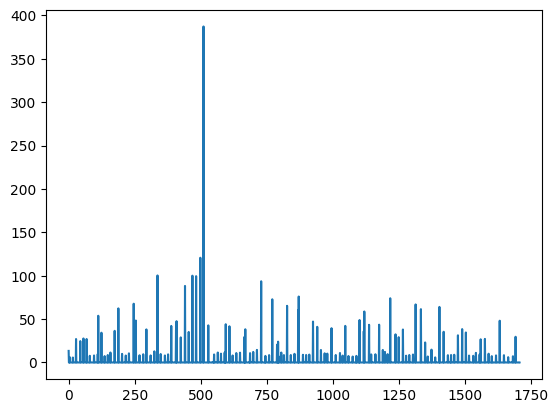

In [46]:
import matplotlib.pyplot as plt
plt.plot(diff)

In [48]:
key = "Behavior.HarpEnvironmentSensor.SensorData"
data = nwb.acquisition[key][:]
diff_cont = np.diff(data['Time'])
diff_cont

array([0.396608, 0.396608, 0.396608, ..., 0.396608, 0.396608, 0.396608])

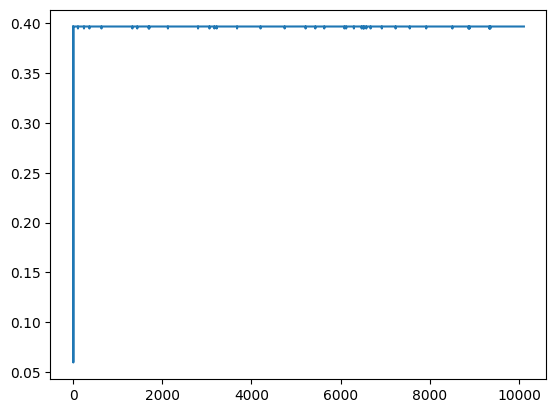

In [49]:
plt.plot(diff_cont)

In [56]:
unique_intervals = np.unique(np.round(diff))

In [57]:
unique_intervals

array([  0.,   1.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,  14.,
        15.,  17.,  21.,  23.,  24.,  25.,  27.,  28.,  29.,  30.,  31.,
        32.,  34.,  35.,  36.,  37.,  38.,  40.,  41.,  42.,  43.,  44.,
        47.,  48.,  49.,  54.,  59.,  60.,  61.,  62.,  64.,  65.,  67.,
        68.,  73.,  74.,  76.,  88.,  94.,  99., 100., 121., 387.])

In [20]:
register_mappings = {
    "Behavior.HarpBehavior.PwmStart": ["PwmDO2"], # EVENT
    "Behavior.HarpBehavior.PwmStop": ["PwmDO2"], # EVENT
    "Behavior.HarpBehavior.PulseSupplyPort0": ["PulseSupplyPort0"], # EVENT
    "Behavior.HarpOlfactometer.OdorValveState": ["Valve0", "Valve1", "Valve2"], # EVENT
    "Behavior.HarpOlfactometer.EndValveState": ["EndValve0"], # EVENT
    "Behavior.HarpLickometer.LickState": ["Channel0"], # EVENT
    "Behavior.HarpBehavior.DigitalInputState": ["DIPort0"], # CONTINUOUS
    "Behavior.HarpOlfactometer.Channel0ActualFlow": ["Channel0ActualFlow"], # CONTINUOUS
    "Behavior.HarpOlfactometer.Channel1ActualFlow": ["Channel1ActualFlow"], # CONTINUOUS
    "Behavior.HarpOlfactometer.Channel2ActualFlow": ["Channel2ActualFlow"], # CONTINUOUS
    "Behavior.HarpOlfactometer.Channel3ActualFlow": ["Channel3ActualFlow"], # CONTINUOUS
    "Behavior.HarpOlfactometer.Channel4ActualFlow": ["Channel4ActualFlow"], # CONTINUOUS
    "Behavior.HarpSniffDetector.RawVoltage": ["RawVoltage"], # CONTINUOUS
    "Behavior.HarpStepperDriver.AccumulatedSteps": ["Motor0, Motor1, Motor2, Motor3"], # CONTINUOUS
    "Behavior.HarpTreadmill.SensorData": ["Encoder", "Torque", "TorqueLoadCurrent"], # CONTINUOUS
    "Behavior.HarpEnvironmentSensor.SensorData": ["Pressure", "Temperature", "Humidity"] # CONTINUOUS
}

In [35]:
def is_event(times, threshold: float=1):
    if times.shape[0] < 3:
        return True, 0
    
    deltas = np.diff(times)
    mean_delta = np.mean(deltas)

    return bool(mean_delta > threshold), mean_delta

In [36]:
register_event_timseries_classification = {}

for device, registers in register_mappings.items():
    for register in registers:
        if device not in nwb.acquisition.keys():
            continue
        
        data = nwb.acquisition[device][:]["Time"]
        is_this_event = is_event(data)
        if device in register_event_timseries_classification:
            register_event_timseries_classification[device].append((register, is_this_event))
        else:
            register_event_timseries_classification[device] = [(register, is_this_event)]


In [23]:
from pprint import pprint
pprint(register_event_timseries_classification)

{'Behavior.HarpBehavior.DigitalInputState': [('DIPort0',
                                              (False,
                                               np.float64(0.0019862846223606023)))],
 'Behavior.HarpBehavior.PulseSupplyPort0': [('PulseSupplyPort0',
                                             (True,
                                              np.float64(32.58860642622897)))],
 'Behavior.HarpBehavior.PwmStart': [('PwmDO2',
                                     (True, np.float64(17.28444786086962)))],
 'Behavior.HarpBehavior.PwmStop': [('PwmDO2', True)],
 'Behavior.HarpEnvironmentSensor.SensorData': [('Pressure',
                                                (False,
                                                 np.float64(0.39656781881119))),
                                               ('Temperature',
                                                (False,
                                                 np.float64(0.39656781881119))),
                               

In [96]:
times = np.diff(nwb.acquisition["Behavior.HarpOlfactometer.Channel0ActualFlow"][:]['Time'])
mean_diff_freq = np.mean(times)

mean_diff_freq

np.float64(0.10781764727528281)

In [ ]:
nwb.acquisition["Behavior.HarpTreadmill.SensorData"][:]["Time"]

id
0          1.109408e+06
1          1.109408e+06
2          1.109408e+06
3          1.109408e+06
4          1.109408e+06
               ...     
1002530    1.113418e+06
1002531    1.113418e+06
1002532    1.113418e+06
1002533    1.113418e+06
1002534    1.113418e+06
Name: Time, Length: 1002535, dtype: float64

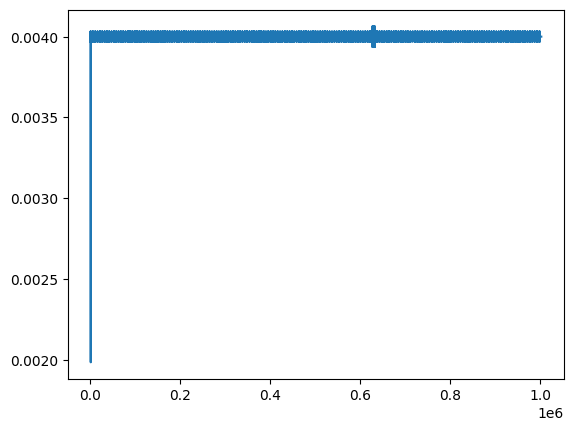

In [39]:
plt.plot(np.diff(nwb.acquisition["Behavior.HarpTreadmill.SensorData"][:]["Time"]))

In [48]:
from pynwb.base import TimeSeries
from pynwb.base import ProcessingModule

In [78]:
if "behavior" not in nwb.processing:
    processing_module = ProcessingModule(name='behavior', description='behavioral timeseries data')
else:
    processing_module = nwb.processing["behavior"]

In [79]:
for key, items in register_event_timseries_classification.items():
    for item in items:
        if item[1]: # classified as event, skip timeseries
            continue
        
        print(key)
        timestamps = nwb.acquisition[key][:]["Time"].to_numpy()
        data = nwb.acquisition[key][:][item[0]].to_numpy()
        ts = TimeSeries(name=f"{key}.{item[0]}", data=data, timestamps=timestamps, unit="V")

        processing_module.add(ts)


Behavior.HarpOlfactometer.Channel3ActualFlow
Behavior.HarpOlfactometer.Channel4ActualFlow
Behavior.HarpSniffDetector.RawVoltage
Behavior.HarpTreadmill.SensorData
Behavior.HarpTreadmill.SensorData
Behavior.HarpTreadmill.SensorData
Behavior.HarpEnvironmentSensor.SensorData
Behavior.HarpEnvironmentSensor.SensorData
Behavior.HarpEnvironmentSensor.SensorData


In [80]:
processing_module.data_interfaces

{'Behavior.HarpOlfactometer.Channel3ActualFlow.Channel3ActualFlow': Behavior.HarpOlfactometer.Channel3ActualFlow.Channel3ActualFlow pynwb.base.TimeSeries at 0x140088093431456
 Fields:
   comments: no comments
   conversion: 1.0
   data: [1000.2789  1000.3718   999.2665  ... 1000.2789   999.7555  1000.55774]
   description: no description
   interval: 1
   offset: 0.0
   resolution: -1.0
   timestamps: [1109408.394144 1109408.44416  1109408.494112 ... 1113418.14416
  1113418.194112 1113418.24416 ]
   timestamps_unit: seconds
   unit: V,
 'Behavior.HarpOlfactometer.Channel4ActualFlow.Channel4ActualFlow': Behavior.HarpOlfactometer.Channel4ActualFlow.Channel4ActualFlow pynwb.base.TimeSeries at 0x140088093435392
 Fields:
   comments: no comments
   conversion: 1.0
   data: [1000.1862   999.0566   999.76416 ...  899.33484  900.23584  900.     ]
   description: no description
   interval: 1
   offset: 0.0
   resolution: -1.0
   timestamps: [1109408.35408  1109408.404096 1109408.45408  ... 111

In [27]:
register_event_timseries_classification.keys()

dict_keys(['Behavior.HarpBehavior.PwmStart', 'Behavior.HarpBehavior.PwmStop', 'Behavior.HarpBehavior.PulseSupplyPort0', 'Behavior.HarpOlfactometer.OdorValveState', 'Behavior.HarpOlfactometer.EndValveState', 'Behavior.HarpLickometer.LickState', 'Behavior.HarpBehavior.DigitalInputState', 'Behavior.HarpOlfactometer.Channel0ActualFlow', 'Behavior.HarpOlfactometer.Channel1ActualFlow', 'Behavior.HarpOlfactometer.Channel2ActualFlow', 'Behavior.HarpOlfactometer.Channel3ActualFlow', 'Behavior.HarpOlfactometer.Channel4ActualFlow', 'Behavior.HarpSniffDetector.RawVoltage', 'Behavior.HarpTreadmill.SensorData', 'Behavior.HarpEnvironmentSensor.SensorData'])

In [44]:
event_table_dict = {"timestamp": [], "event_name": [], "event_data": []}

for key, items in register_event_timseries_classification.items():
    for item in items:
        if not item[1][0]: # continuous
            continue
        
        data = nwb.acquisition[key][:]
        event_table_dict["timestamp"].extend(data["Time"].tolist())
        event_table_dict["event_name"].extend([key for i in range(len(data))])
        event_table_dict["event_data"].extend(data[item[0]].tolist())
    

In [45]:
event_table_df = pd.DataFrame(event_table_dict)

In [46]:
event_table_df

,timestamp,event_name,event_data
0,1.109411e+06,Behavior.HarpBehavior.PwmStart,False
1,1.109424e+06,Behavior.HarpBehavior.PwmStart,True
2,1.109431e+06,Behavior.HarpBehavior.PwmStart,True
3,1.109437e+06,Behavior.HarpBehavior.PwmStart,True
4,1.109465e+06,Behavior.HarpBehavior.PwmStart,True
...,...,...,...
4071,1.113388e+06,Behavior.HarpLickometer.LickState,False
4072,1.113388e+06,Behavior.HarpLickometer.LickState,True
4073,1.113388e+06,Behavior.HarpLickometer.LickState,False
4074,1.113388e+06,Behavior.HarpLickometer.LickState,True


In [47]:
from ndx_events.events import EventsTable

In [48]:
event_table = EventsTable.from_dataframe(event_table_df, name="events", table_description="Event table for VR Foraging task")

In [49]:
event_table

,timestamp,event_name,event_data
id,,,
0,1.109411e+06,Behavior.HarpBehavior.PwmStart,False
1,1.109424e+06,Behavior.HarpBehavior.PwmStart,True
2,1.109431e+06,Behavior.HarpBehavior.PwmStart,True
3,1.109437e+06,Behavior.HarpBehavior.PwmStart,True
